In [1]:
import numpy as np
from pathlib import Path
import time
import matplotlib.pyplot as plt
start_time = time.time()

import xobjects as xo
import xtrack as xt
import xpart as xp
import xobjects as xo
import xcoll as xc

# import apertls
from matplotlib.colors import LogNorm

import gzip
from typing import Union

import awkward as ak
import pandas as pd
import re
from datetime import datetime

# Functions

In [6]:
def moindre_carres(ref_data, sim_data, mask_None):
    distances = []
    for turn in range(len(sim_data)):
        distances.append(np.linalg.norm(sim_data[turn][~mask_None] - ref_data[~mask_None]))
    best_turn = np.nanargmin(distances)

    # distances = np.linalg.norm(sim_data - ref_data, axis=1)
    # best_turn = np.argmin(distances)
    return int(best_turn), distances

In [3]:
def get_straight_line(t, t1, r1, t2, r2):
    alpha = (r2 - r1) / (t2 - t1)
    return r1 + alpha * (t - t1)

In [4]:
def insert_monitor_bpms(line, num_turns, num_particles):
    tt = line.get_table()
    bph_list = tt.rows['bph.*..0'].name
    env = line.env
    insertions = []
    monitors_elems = []
    monitorBPM_names = []
    for name in bph_list:
        monitorBPM_names.append(name.split('.')[0] + '.' + name.split('.')[1])

        monitors_elems.append(xt.ParticlesMonitor(_context=line._context, 
                                                            num_particles=num_particles, 
                                                            start_at_turn=0, 
                                                            stop_at_turn=num_turns+1))
        env.elements[f'{name}_monitor'] = monitors_elems[-1]
        insertions.append(env.place(f'{name}_monitor', at=line.get_s_position(name)))
    line.insert(insertions, s_tol=1e-6)
    return np.array(monitorBPM_names), monitors_elems

def install_tidp(line, block_mvt=29e-3):
    tidp_ap_tot = 147e-3
    line.discard_tracker()
    tidp = xc.EverestCollimator(length=4.3, material=xc.materials.Carbon, jaw_L= tidp_ap_tot/2 + block_mvt, jaw_R = -tidp_ap_tot/2 + block_mvt)
    line.collimators.install(names=['tidp.11434'], elements=[tidp])
    return tidp

In [5]:
def post_processing_simulation(line, monitors_elems, part):
    turn_max = part.at_turn[0]
    tt = line.get_table()
    monitors = tt.rows['.*monitor.*'].name
    s_positions_monitors = tt.rows['.*monitor.*'].s
    x_positions = []

    data_mean = {}
    for i, monitor in enumerate(monitors):
        masked_x = ak.Array([monitors_elems[i].x[p][monitors_elems[i].state[p] > 0] for p in range(len(monitors_elems[i].x))])
        data_mean[monitor] = ak.mean(masked_x, axis=0)

    for turn in range(turn_max):
        x_turn = []
        for monitor in monitors:
            x_turn.append(data_mean[monitor][turn])
        x_positions.append(x_turn)
    x_positions = ak.Array(x_positions)
    
    return s_positions_monitors, x_positions

# BPM class post mortem

In [7]:
from typing import Optional, Tuple, Union, Set, List
import re

class BPMBehavior(ak.Record):
    pass

class BPMCollectionBehavior(ak.Array):
    @property
    def full_index(self):
        if not hasattr(self, '_full_index'):
            self._build_full_index()
        return self._full_index
    
    @property
    def index(self):
        if not hasattr(self, '_index'):
            self._build_index()
        return self._index
    
    @property
    def bpms_hor(self):
        if not hasattr(self, '_bpms_hor'):
            self._build_bpms_hor()
        return self._bpms_hor
    
    @property
    def bpms_ver(self):
        if not hasattr(self, '_bpms_ver'):
            self._build_bpms_ver()
        return self._bpms_ver
    
    @property
    def hor_turn_position(self):
        if not hasattr(self, '_hor_pos'):
            self._build_hor_pos()
        return self._hor_pos
    
    @property
    def ver_turn_position(self):
        if not hasattr(self, '_ver_pos'):
            self._build_ver_pos()
        return self._ver_pos
    
    def _build_full_index(self):
        self._full_index = {}

        bpm_entries = []

        # Collect all BPMs with metadata
        for crate in self.fields:
            for i, bpm in enumerate(self[crate]['value']['channelNames'][0]):
                if bpm != 'SPARE':
                    split_bpm = bpm.split('.')
                    bpm_name = split_bpm[0].lower() + '.' + split_bpm[1]
                    plane = split_bpm[2]
                    position = self[crate]['value']['positions'][0][i]

                    bpm_entries.append({
                        'bpm_name': bpm_name,
                        'plane': plane,
                        'crate': crate,
                        'position': position
                    })

        # Sort BPMs by natural order (e.g., bpm.1, bpm.2, ..., bpm.10)
        def natural_key(entry):
            # Extract the numeric part of the BPM name for sorting
            match = re.search(r'(\d+)$', entry['bpm_name'])
            return int(match.group(1)) if match else entry['bpm_name']

        bpm_entries.sort(key=natural_key)

        # Build _full_index with sorted BPMs
        for idx, entry in enumerate(bpm_entries):
            name = entry['bpm_name']
            if name not in self._full_index:
                self._full_index[name] = {}
            self._full_index[name]['plane'] = entry['plane']
            self._full_index[name]['index'] = idx
            self._full_index[name]['crate'] = entry['crate']
            self._full_index[name]['positions'] = entry['position']
    
    def _build_index(self):
        self._index = {}
        if not hasattr(self, '_full_index'):
            self._build_full_index()
        for i, bpm in enumerate(self._full_index):
            if bpm not in self._index:
                self._index[bpm] = i

    def _build_bpms_hor(self):
        if not hasattr(self, '_full_index'):
            self._build_full_index()
        bpms = [bpm for bpm in self._full_index if self._full_index[bpm]['plane'] == 'H']
        self._bpms_hor = ak.Array(sorted(bpms, key=lambda bpm: self._full_index[bpm]['index'])) #BPMs are sorted by index
    
    def _build_bpms_ver(self):
        if not hasattr(self, '_full_index'):
            self._build_full_index()
        bpms = [bpm for bpm in self._full_index if self._full_index[bpm]['plane'] == 'V']
        self._bpms_ver = ak.Array(sorted(bpms, key=lambda bpm: self._full_index[bpm]['index'])) #BPMs are sorted by index

    def _build_hor_pos(self):
        if not hasattr(self, '_bpms_hor'):
            self._build_bpms_hor()
        self._hor_pos = ak.Array([self._full_index[bpm]['positions'] for bpm in self._bpms_hor])
    
    def _build_ver_pos(self):
        if not hasattr(self, '_bpms_ver'):
            self._build_bpms_ver()
        self._ver_pos = ak.Array([self._full_index[bpm]['positions'] for bpm in self._bpms_ver])


ak.behavior["*", "BPMCollection"] = BPMCollectionBehavior

# Comparing the two versions of matched orbits

In [9]:
# xsuite line with MD orbit
line = xt.Line.from_json('../injection_lines/sps_orbit_md_20250616.json')
tt = line.get_table()
tw_ref = line.twiss()

line2 = xt.Line.from_json('../injection_lines/sps_orbit_md_20250616_v2.json')
tt2 = line2.get_table()
tw_ref2 = line2.twiss()

Loading line from dict:   0%|          | 0/36506 [00:00<?, ?it/s]

Done loading line from dict.           


Loading line from dict:   0%|          | 0/36506 [00:00<?, ?it/s]

Done loading line from dict.           


In [10]:
# Orbit data
path_orbit = Path('/Users/lisepauwels/sps_simulations/MD_data/20250616/bpm/SPS.USER.MD2/2025.06.16.18.44.00.711409.parquet')
bpm_orbit = ak.Array(ak.from_parquet(path_orbit), with_name='BPMCollection')

mask_bpm = np.array([True if bpm not in ['bph.10208', 'bph.31808', 'bph.63008', 'bph.63608', 'bph.62008', 'bph.11831'] else False for bpm in bpm_orbit.bpms_hor])
s_positions_bpms = np.array([line.get_s_position(f'{bpm}..0') for bpm in bpm_orbit.bpms_hor])

mean_orbit = ak.mean(bpm_orbit.hor_turn_position, axis=1)
# mean_orbit = ak.mean(bpm_orbit.hor_turn_position[mask_bpm], axis=1)

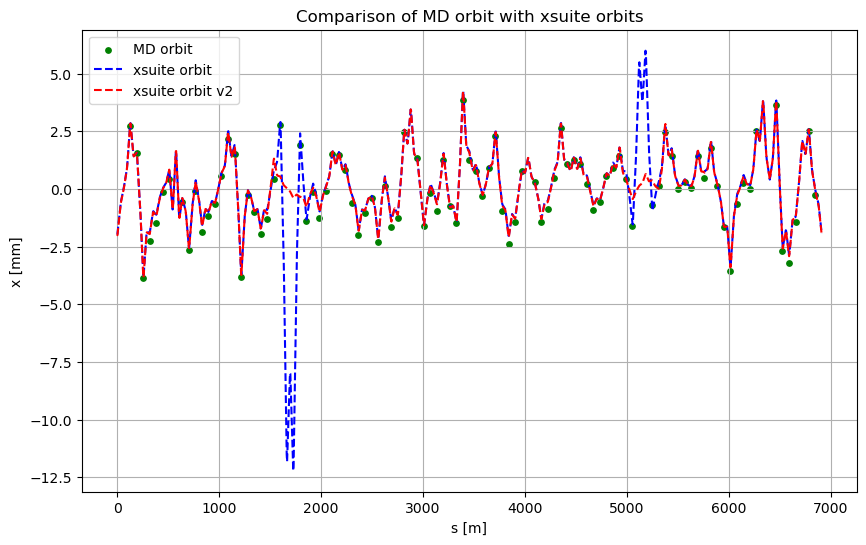

In [47]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(s_positions_bpms[mask_bpm], mean_orbit[mask_bpm], s=15, marker='o', color='green', label='MD orbit')
ax.plot(tw_ref.s, tw_ref.x*1e3, '--', color='blue', label='xsuite orbit')
ax.plot(tw_ref2.s, tw_ref2.x*1e3, '--', color='red', label='xsuite orbit v2')
ax.set_xlabel('s [m]')
ax.set_ylabel('x [mm]')
ax.set_title('Comparison of MD orbit with xsuite orbits')
ax.legend()
ax.grid()

In [70]:
mask1 = []

for name in tw_ref.name:
    if name.startswith('bph.'):
        if '..1' in name:
            nn = name.split('.')[0] +'.' + name.split('.')[1]
            if nn in bpm_orbit.bpms_hor:
                mask1.append(True)
            else:
                mask1.append(False)
        else:
            mask1.append(False)
    else:
        mask1.append(False)

mask2 = []

for name in tw_ref2.name:
    if name.startswith('bph.'):
        if '..1' in name:
            nn = name.split('.')[0] +'.' + name.split('.')[1]
            if nn in bpm_orbit.bpms_hor:
                mask2.append(True)
            else:
                mask2.append(False)
        else:
            mask2.append(False)
    else:
        mask2.append(False)

mask1 = np.array(mask1)
mask2 = np.array(mask2)

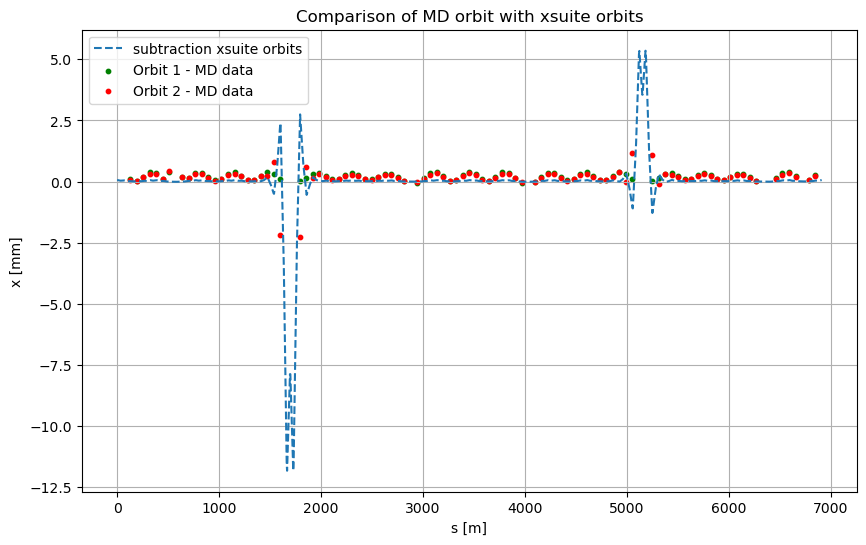

In [82]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(tw_ref.s, tw_ref.x*1e3 - tw_ref2.x*1e3, '--', label='subtraction xsuite orbits')
ax.scatter(s_positions_bpms[mask_bpm], tw_ref.x[mask1][mask_bpm]*1e3 - mean_orbit[mask_bpm], s=10, marker='o', color='green', label='Orbit 1 - MD data')
ax.scatter(s_positions_bpms[mask_bpm], tw_ref2.x[mask2][mask_bpm]*1e3 - mean_orbit[mask_bpm], s=10, marker='o', color='red', label='Orbit 2 - MD data')
ax.set_xlabel('s [m]')
ax.set_ylabel('x [mm]')
ax.set_title('Comparison of MD orbit with xsuite orbits')
ax.legend()
ax.grid()

Basically where it diverges most is where we lack data because no BPM, so I would say we go for the second version to avoid having a -12.5mm spike that is as big as the bump on the tidp...

# Radial steering

## v1 line

Loading line from dict:   0%|          | 0/36506 [00:00<?, ?it/s]

Done loading line from dict.           


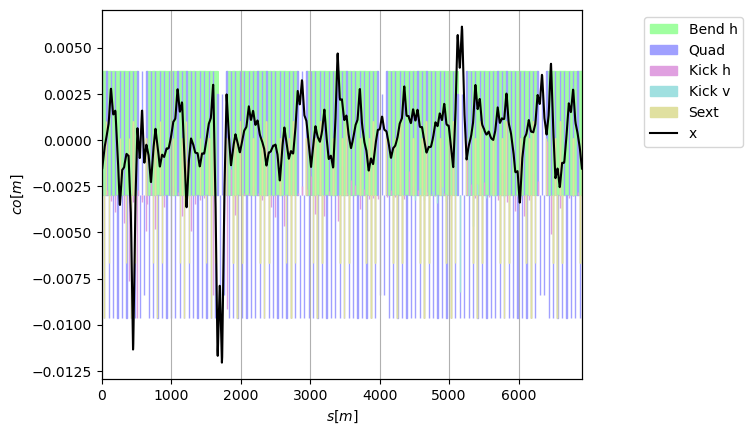

In [117]:
line = xt.Line.from_json('../injection_lines/sps_orbit_md_20250616.json')
tw_ref = line.twiss()
cav, _ = line.get_elements_of_type(xt.Cavity)
line['bump.11207'] = 1.19603e-4
line['bump.11407'] = -9.3027e-5
line['bump.11607'] = 1.19603e-4

line.ref['mdh.11207'].knl[0] += line.vars['bump.11207']
line.ref['mdh.11407'].knl[0] += line.vars['bump.11407']
line.ref['mdh.11607'].knl[0] += line.vars['bump.11607']


line.vars['qph_setvalue'] = 0.5
line.vars['qpv_setvalue'] = 0.5
line.vars['qh_setvalue'] = line.vars['qx0']._value + 0.05
line.vars['qv_setvalue'] = line.vars['qy0']._value + 0.05
tw_before_with_bump = line.twiss()

tw_before_with_bump.plot('x')

In [118]:
#Context and parameters
context = xo.ContextCpu()

num_particles  = 10
plane = 'DPneg'
delta_emp = 0.307*get_straight_line(1.967, 1.027,0, 1.967, -22e-3)
sweep = delta_emp * cav[0].frequency * tw_ref.slip_factor
sweep = -abs(sweep) if plane == 'DPpos' else abs(sweep)
num_turns = 7000

#Setting cavities to the same frequency and phase, plus setting the voltage
cavity_elements, cavity_names = line.get_elements_of_type(xt.Cavity)

for name in cavity_names:
    line[name].frequency = 200e6
    line[name].lag = 180
line['acl.31735'].voltage = 0 #setting 800 cav to 0V
line['actcse.31632'].voltage = 3.5e6

In [119]:
monitor_names, monitors_elems = insert_monitor_bpms(line, num_turns, num_particles)
tidp = install_tidp(line)
tw = line.twiss()
part = xp.generate_matched_gaussian_bunch(nemitt_x=2e-6,
                                          nemitt_y=2e-6,
                                          sigma_z=0.224, num_particles=num_particles, line=line)

Slicing line:   0%|          | 0/33114 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/33218 [00:00<?, ?it/s]

*** Maximum RMS bunch length 0.23610110213554214m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.2239999998900487
--> Emittance: 0.30344800513407316


In [120]:
rf_sweep = xc.RFSweep(line)
rf_sweep.info(sweep=sweep, num_turns=num_turns)

line.scattering.enable()
rf_sweep.track(sweep=sweep, particles=part, num_turns=num_turns, time=True, with_progress=True)
line.scattering.disable()

The current frequency is 200000000.0Hz, adding 0.3465359675620472Hz per turn until 200002425.75177294 (for 7000 turns).
This sweep will move the center of the bucket with Δδ = -0.006824942880873933 (-1.0549472351770173 buckets).


Tracking:   0%|          | 0/7000 [00:00<?, ?it/s]

All particles lost at turn 6606, stopped sweep at 2266.345242Hz.


In [121]:
# MD data
path_data = Path('/Users/lisepauwels/sps_simulations/MD_data/20250616/bpm/SPS.USER.MD2/2025.06.16.20.04.15.339607.parquet')
md_data = ak.Array(ak.from_parquet(path_data), with_name='BPMCollection')

In [125]:
s_positions_monitors, x_positions = post_processing_simulation(line, monitors_elems, part)

mask_monitors = [True if name in bpm_orbit.bpms_hor[mask_bpm] else False for name in monitor_names]
mask_None = ak.is_none(md_data.hor_turn_position[mask_bpm][:, -1])
monitor_names = np.array(monitor_names)
mask_ba3 = np.array([True if bpm.split('.')[1][0] == '3' else False for bpm in monitor_names[mask_monitors][mask_None]])
best_turn, distances = moindre_carres(md_data.hor_turn_position[mask_bpm][:, -1], x_positions[:, mask_monitors]*1e3, mask_None )

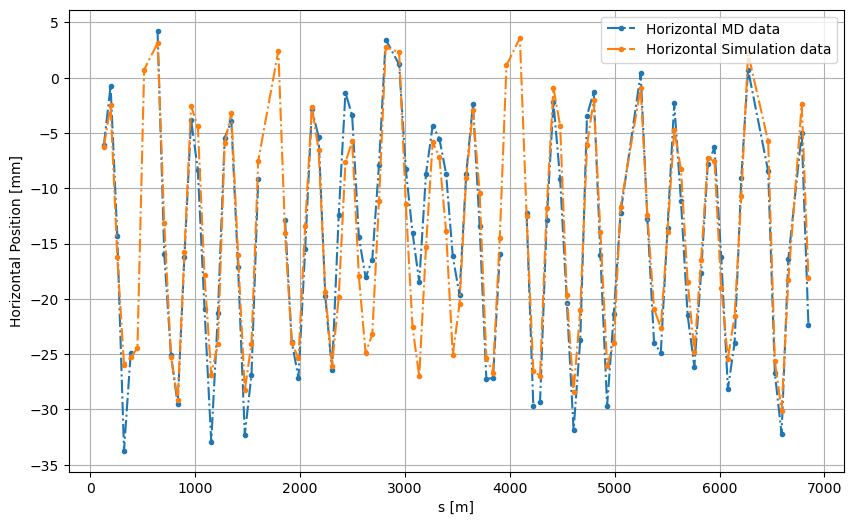

In [126]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(s_positions_bpms[mask_bpm], md_data.hor_turn_position[mask_bpm][:, -1], '.-.', label='Horizontal MD data')
#ax.plot(s_positions_bpms[mask_bpm], md_data.hor_turn_position[mask_bpm][:, 0], '.-.', label='Horizontal MD data first turn')
ax.plot(s_positions_monitors[mask_monitors], x_positions[best_turn][mask_monitors]*1e3, '.-.', label='Horizontal Simulation data')
ax.set_xlabel('s [m]')
ax.set_ylabel('Horizontal Position [mm]')
ax.grid()
ax.legend()

## v2 line


Loading line from dict:   0%|          | 0/36506 [00:00<?, ?it/s]

Done loading line from dict.           


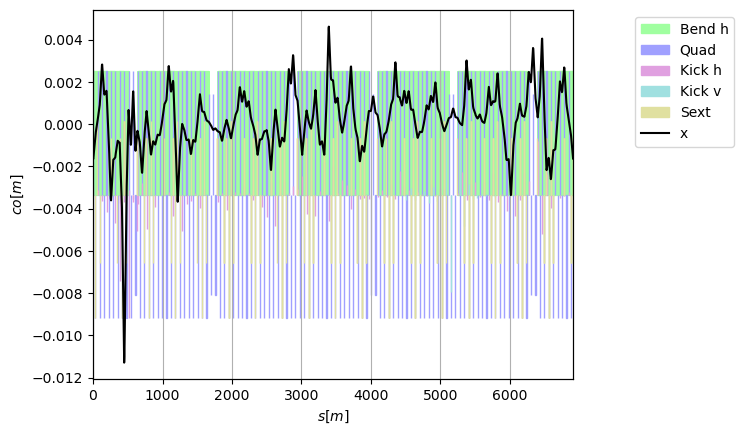

In [127]:
line = xt.Line.from_json('../injection_lines/sps_orbit_md_20250616_v2.json')
tw_ref = line.twiss()
cav, _ = line.get_elements_of_type(xt.Cavity)
line['bump.11207'] = 1.19603e-4
line['bump.11407'] = -9.3027e-5
line['bump.11607'] = 1.19603e-4

line.ref['mdh.11207'].knl[0] += line.vars['bump.11207']
line.ref['mdh.11407'].knl[0] += line.vars['bump.11407']
line.ref['mdh.11607'].knl[0] += line.vars['bump.11607']


line.vars['qph_setvalue'] = 0.5
line.vars['qpv_setvalue'] = 0.5
line.vars['qh_setvalue'] = line.vars['qx0']._value + 0.05
line.vars['qv_setvalue'] = line.vars['qy0']._value + 0.05
tw_before_with_bump = line.twiss()

tw_before_with_bump.plot('x')

In [128]:
#Context and parameters
context = xo.ContextCpu()

num_particles  = 10
plane = 'DPneg'
delta_emp = 0.307*get_straight_line(1.967, 1.027,0, 1.967, -22e-3)
sweep = delta_emp * cav[0].frequency * tw_ref.slip_factor
sweep = -abs(sweep) if plane == 'DPpos' else abs(sweep)
num_turns = 7000

#Setting cavities to the same frequency and phase, plus setting the voltage
cavity_elements, cavity_names = line.get_elements_of_type(xt.Cavity)

for name in cavity_names:
    line[name].frequency = 200e6
    line[name].lag = 180
line['acl.31735'].voltage = 0 #setting 800 cav to 0V
line['actcse.31632'].voltage = 3.5e6

In [129]:
monitor_names, monitors_elems = insert_monitor_bpms(line, num_turns, num_particles)
tidp = install_tidp(line)
tw = line.twiss()
part = xp.generate_matched_gaussian_bunch(nemitt_x=2e-6,
                                          nemitt_y=2e-6,
                                          sigma_z=0.224, num_particles=num_particles, line=line)

Slicing line:   0%|          | 0/33114 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/33218 [00:00<?, ?it/s]

*** Maximum RMS bunch length 0.2361011021355421m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.2239999998900487
--> Emittance: 0.30345766183315864


In [130]:
rf_sweep = xc.RFSweep(line)
rf_sweep.info(sweep=sweep, num_turns=num_turns)

line.scattering.enable()
rf_sweep.track(sweep=sweep, particles=part, num_turns=num_turns, time=True, with_progress=True)
line.scattering.disable()

The current frequency is 200000000.0Hz, adding 0.3465151460080551Hz per turn until 200002425.60602206 (for 7000 turns).
This sweep will move the center of the bucket with Δδ = -0.006824967169774727 (-1.0549174186771397 buckets).


Tracking:   0%|          | 0/7000 [00:00<?, ?it/s]

In [131]:
# MD data
path_data = Path('/Users/lisepauwels/sps_simulations/MD_data/20250616/bpm/SPS.USER.MD2/2025.06.16.20.04.15.339607.parquet')
md_data = ak.Array(ak.from_parquet(path_data), with_name='BPMCollection')

In [160]:
s_positions_monitors, x_positions2 = post_processing_simulation(line, monitors_elems, part)

mask_monitors = [True if name in bpm_orbit.bpms_hor[mask_bpm] else False for name in monitor_names]
mask_None = ak.is_none(md_data.hor_turn_position[mask_bpm][:, -1])
mask_ba3 = np.array([True if bpm.split('.')[1][0] == '3' else False for bpm in monitor_names[mask_monitors][mask_None]])
best_turn2, distances2 = moindre_carres(md_data.hor_turn_position[mask_bpm][:, -1], x_positions2[:, mask_monitors]*1e3, mask_None )

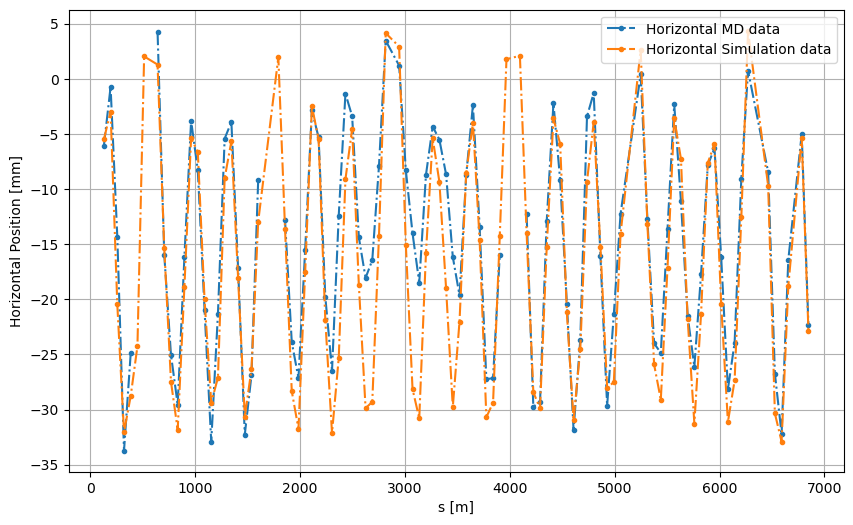

In [133]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(s_positions_bpms[mask_bpm], md_data.hor_turn_position[mask_bpm][:, -1], '.-.', label='Horizontal MD data')
#ax.plot(s_positions_bpms[mask_bpm], md_data.hor_turn_position[mask_bpm][:, 0], '.-.', label='Horizontal MD data first turn')
ax.plot(s_positions_monitors[mask_monitors], x_positions2[best_turn][mask_monitors]*1e3, '.-.', label='Horizontal Simulation data')
ax.set_xlabel('s [m]')
ax.set_ylabel('Horizontal Position [mm]')
ax.grid()
ax.legend()

In [161]:
best_turn2

3168

## Comparison

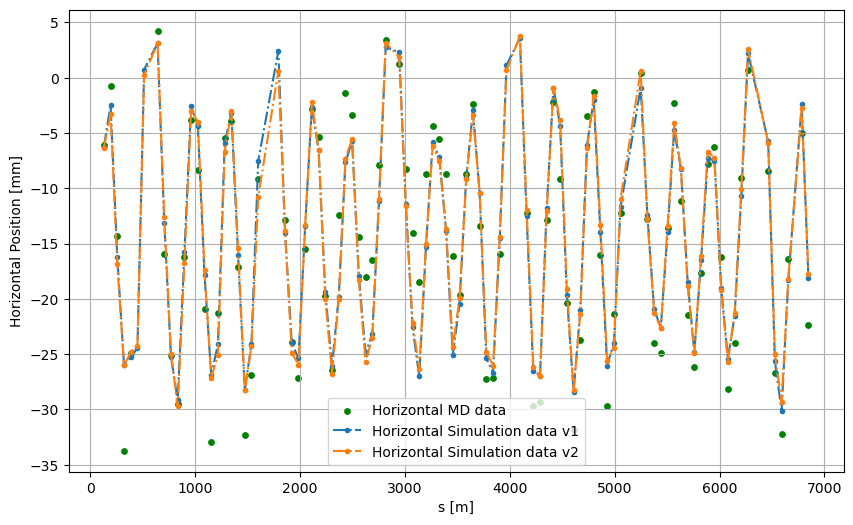

In [162]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(s_positions_bpms[mask_bpm][~mask_None], md_data.hor_turn_position[mask_bpm][:, -1][~mask_None], s=15, marker= 'o', color='green', label='Horizontal MD data')
#ax.plot(s_positions_bpms[mask_bpm], md_data.hor_turn_position[mask_bpm][:, 0], '.-.', label='Horizontal MD data first turn')
ax.plot(s_positions_monitors[mask_monitors], x_positions[best_turn][mask_monitors]*1e3, '.-.', label='Horizontal Simulation data v1')
ax.plot(s_positions_monitors[mask_monitors], x_positions2[best_turn2][mask_monitors]*1e3, '.-.', label='Horizontal Simulation data v2')
ax.set_xlabel('s [m]')
ax.set_ylabel('Horizontal Position [mm]')
ax.grid()
ax.legend()

In [174]:
mask_ba3 = np.array([True if bpm.split('.')[1][0] == '3' else False for bpm in monitor_names])
mask_ba3_bpms = np.array([True if bpm.split('.')[1][0] == '3' else False for bpm in bpm_orbit.bpms_hor[mask_bpm]])

In [176]:
norm_v1 = np.linalg.norm(x_positions[best_turn][mask_monitors][~mask_None]*1e3 - md_data.hor_turn_position[mask_bpm][:, -1][~mask_None])
norm_v2 = np.linalg.norm(x_positions2[best_turn2][mask_monitors][~mask_None]*1e3 - md_data.hor_turn_position[mask_bpm][:, -1][~mask_None])
print(f'Norm v1: {norm_v1}, Norm v2: {norm_v2}')

Norm v1: 30.604546867327414, Norm v2: 31.004625947052084


In [156]:
# xsuite line with MD orbit
line_v1 = xt.Line.from_json('../injection_lines/sps_orbit_md_20250616.json')
tt = line_v1.get_table()
tw_ref = line_v1.twiss()

line_v2 = xt.Line.from_json('../injection_lines/sps_orbit_md_20250616_v2.json')
tt2 = line_v2.get_table()
tw_ref2 = line_v2.twiss()

Loading line from dict:   0%|          | 0/36506 [00:00<?, ?it/s]

Done loading line from dict.           


Loading line from dict:   0%|          | 0/36506 [00:00<?, ?it/s]

Done loading line from dict.           


In [158]:
print(np.linalg.norm(tw_ref.x[mask1][mask_bpm]*1e3 - mean_orbit[mask_bpm]))
print(np.linalg.norm(tw_ref2.x[mask2][mask_bpm]*1e3 - mean_orbit[mask_bpm]))

2.3233748886685235
4.16146188136919


In [165]:
best_turn, best_turn2

(3978, 3168)

v1 seems to give the best accordance with data, both on simulation level after bump and radial steering and just in terms of orbits. So I will keep v1 for the rest but if at some point there is an issue with these spikes, we will have to switch back. Also, the number of turns that matches the best is way lower in the second line, so somehow it is more unstable ?

NB: linalg.norm gives frobenius norm by default

In [ ]:
np.unique(part.state, return_counts=True)

(array([0, 1]), array([9, 1]))

Most of the particles are dead, so we can assume that these turns are equivalent to the last turn we have during the MD

In [179]:
part.at_element

array([   0, 3797, 3797, 3797, 3797, 3797, 3797, 3797, 3797, 3797])

In [180]:
line.element_names[3797]

'bpcn.12508.a_aper'

# Bump analysis

In [181]:
line = xt.Line.from_json('../injection_lines/sps_orbit_md_20250616.json')
tt = line.get_table()
tw_ref = line.twiss()

Loading line from dict:   0%|          | 0/36506 [00:00<?, ?it/s]

Done loading line from dict.           


## Bump values

In [11]:
bump_correctors = ['mdh.11207', 'mdh.11407', 'mdh.11607']
bump_corrections = {
    -10 : [1.19603e-4, -9.3027e-5, 1.19603e-4],
    -11 : [1.315633e-4, -1.02397e-4, 1.315633e-4],
    -12 : [1.435236e-4, -1.116324e-4, 1.435236e-4],
    -13 : [1.554839e-4, -1.209351e-4, 1.554839e-4],
    -14 : [1.674442e-4, -1.302378e-4, 1.674442e-4],
    -15 : [1.794045e-4, -1.395405e-4, 1.794045e-4],
    -16 : [1.913648e-4, -1.488432e-4, 1.913648e-4],
    -17 : [2.033251e-4, -1.581459e-4, 2.033251e-4],
    -18 : [2.152854e-4, -1.674486e-4, 2.152854e-4],
    -19 : [2.272457e-4, -1.767513e-4, 2.272457e-4],
    -20 : [2.39206e-4, -1.86054e-4, 2.39206e-4]
}


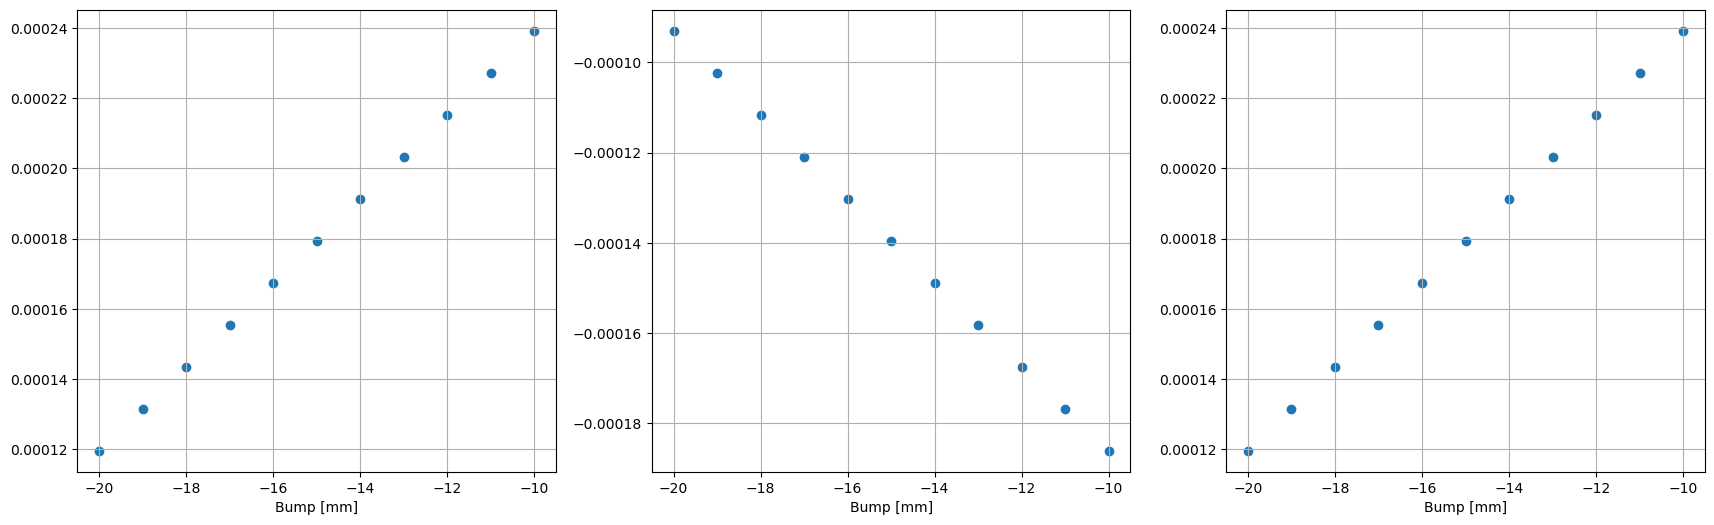

In [193]:
s = np.linspace(-20, -10, 11)
corr = {'mdh.11207': [], 'mdh.11407': [], 'mdh.11607': []}
for bump in bump_corrections:
    corr['mdh.11207'].append(bump_corrections[bump][0])
    corr['mdh.11407'].append(bump_corrections[bump][1])
    corr['mdh.11607'].append(bump_corrections[bump][2])

fig, ax = plt.subplots(1, 3, figsize=(21, 6))
ax[0].scatter(s, corr['mdh.11207'], label='mdh.11207')
ax[1].scatter(s, corr['mdh.11407'], label='mdh.11407')
ax[2].scatter(s, corr['mdh.11607'], label='mdh.11607')

for axis in ax:
    axis.set_xlabel('Bump [mm]')
    axis.grid()

We can just make a function out of it

In [197]:
coeffs_mdh_11207 = np.polyfit(s, corr['mdh.11207'], 1)
coeffs_mdh_11407 = np.polyfit(s, corr['mdh.11407'], 1)
coeffs_mdh_11607 = np.polyfit(s, corr['mdh.11607'], 1)

bump_tidp_mdh_11207 = np.poly1d(coeffs_mdh_11207)
bump_tidp_mdh_11407 = np.poly1d(coeffs_mdh_11407)
bump_tidp_mdh_11607 = np.poly1d(coeffs_mdh_11607)

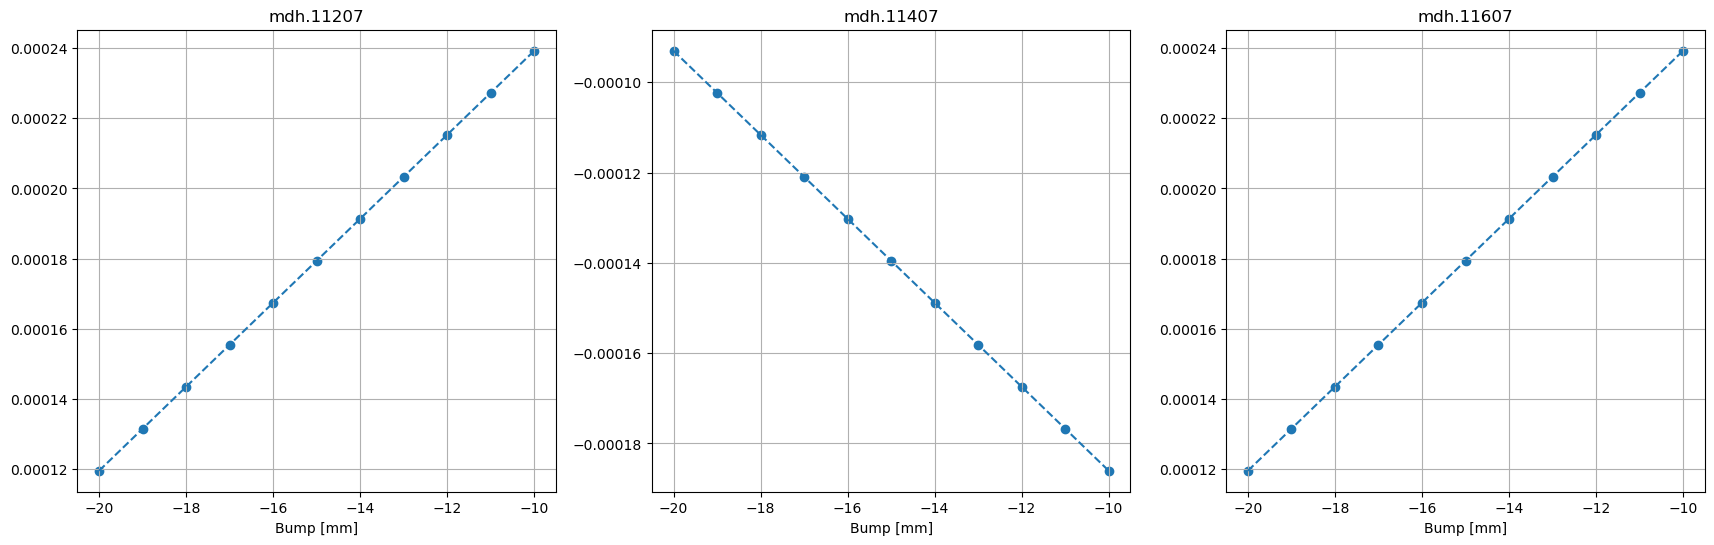

In [198]:
s = np.linspace(-20, -10, 11)
corr = {'mdh.11207': [], 'mdh.11407': [], 'mdh.11607': []}
for bump in bump_corrections:
    corr['mdh.11207'].append(bump_corrections[bump][0])
    corr['mdh.11407'].append(bump_corrections[bump][1])
    corr['mdh.11607'].append(bump_corrections[bump][2])

fig, ax = plt.subplots(1, 3, figsize=(21, 6))
ax[0].scatter(s, corr['mdh.11207'], label='mdh.11207')
ax[0].plot(s, bump_tidp_mdh_11207(s), '--', label='fit mdh.11207')
ax[1].scatter(s, corr['mdh.11407'], label='mdh.11407')
ax[1].plot(s, bump_tidp_mdh_11407(s), '--', label='fit mdh.11407')
ax[2].scatter(s, corr['mdh.11607'], label='mdh.11607')
ax[2].plot(s, bump_tidp_mdh_11607(s), '--', label='fit mdh.11607')
ax[0].set_title('mdh.11207')
ax[1].set_title('mdh.11407')
ax[2].set_title('mdh.11607')
for axis in ax:
    axis.set_xlabel('Bump [mm]')
    axis.grid()

## Plotting bumps

Loading line from dict:   0%|          | 0/36506 [00:00<?, ?it/s]

Done loading line from dict.           


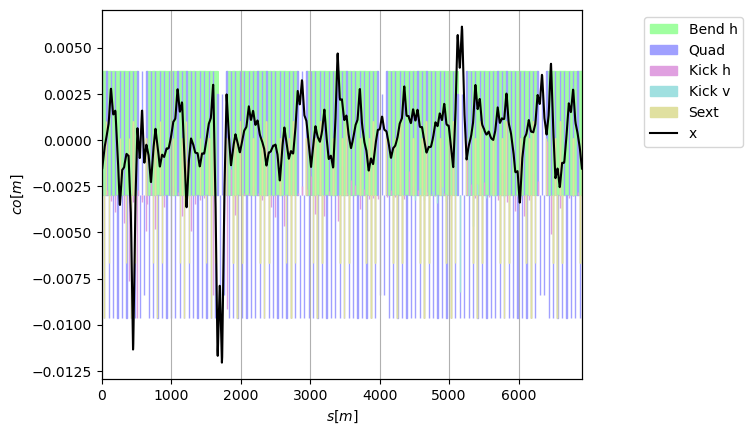

In [205]:
line = xt.Line.from_json('../injection_lines/sps_orbit_md_20250616.json')
tt = line.get_table()
tw_ref = line.twiss()

line['bump.11207'] = corr['mdh.11207'][0]
line['bump.11407'] = corr['mdh.11407'][0]
line['bump.11607'] = corr['mdh.11607'][0]

line.ref['mdh.11207'].knl[0] += line.vars['bump.11207']
line.ref['mdh.11407'].knl[0] += line.vars['bump.11407']
line.ref['mdh.11607'].knl[0] += line.vars['bump.11607']


line.vars['qph_setvalue'] = 0.5
line.vars['qpv_setvalue'] = 0.5
line.vars['qh_setvalue'] = line.vars['qx0']._value + 0.05
line.vars['qv_setvalue'] = line.vars['qy0']._value + 0.05

tw = line.twiss()
tw.plot('x')

In [204]:
idx_tidp = np.where(tw.name == 'tidp.11434')[0][0]
print(tw.x[idx_tidp]*1e3)

-1.1804698585392517


In [211]:
line = xt.Line.from_json('../injection_lines/sps_orbit_md_20250616.json')
tt = line.get_table()
tw_ref = line.twiss()

line['bump.11207'] = 0
line['bump.11407'] = 0
line['bump.11607'] = 0

line.ref['mdh.11207'].knl[0] += line.vars['bump.11207']
line.ref['mdh.11407'].knl[0] += line.vars['bump.11407']
line.ref['mdh.11607'].knl[0] += line.vars['bump.11607']


line.vars['qph_setvalue'] = 0.5
line.vars['qpv_setvalue'] = 0.5
line.vars['qh_setvalue'] = line.vars['qx0']._value + 0.05
line.vars['qv_setvalue'] = line.vars['qy0']._value + 0.05

idx_tidp = np.where(tw_ref.name == 'tidp.11434')[0][0]

Loading line from dict:   0%|          | 0/36506 [00:00<?, ?it/s]

Done loading line from dict.           


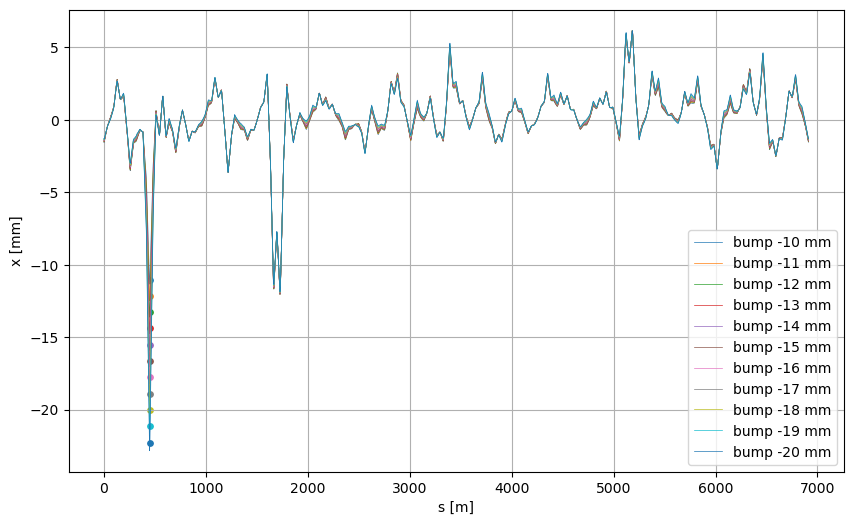

In [216]:
bump_vals_theory = list(bump_corrections.keys())
bump_vals = []
fig, ax = plt.subplots(figsize=(10, 6))
for bump in bump_corrections:
    for i, corrector in enumerate(bump_correctors):
        nn = corrector.split('.')[1]
        line[f'bump.{nn}'] = bump_corrections[bump][i]

    tw = line.twiss()
    bump_vals.append(tw.x[idx_tidp]*1e3)
    ax.plot(tw.s, tw.x*1e3, label=f'bump {bump} mm', lw=0.5)
    ax.scatter(tw.s[idx_tidp], tw.x[idx_tidp]*1e3, s=15, marker='o')
    

ax.set_xlabel('s [m]')
ax.set_ylabel('x [mm]')
ax.legend()
ax.grid()

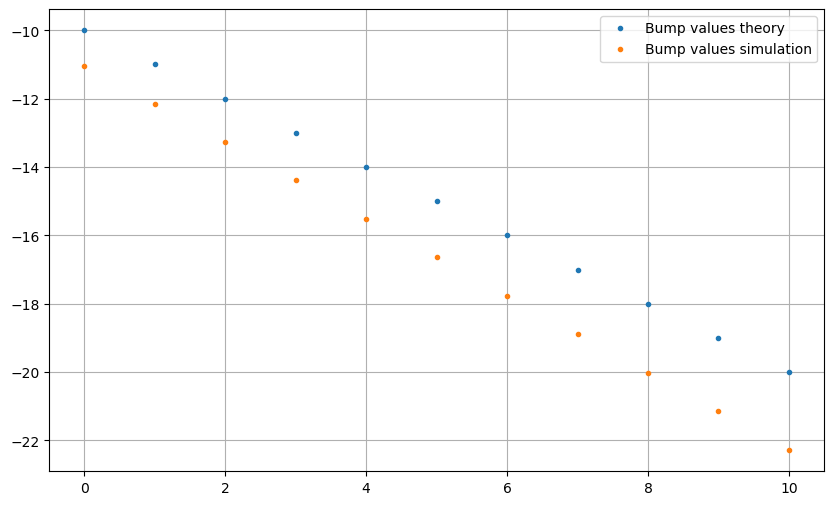

In [221]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(bump_vals_theory, '.', label='Bump values theory')
ax.plot(bump_vals, '.', label='Bump values simulation')
ax.grid()
ax.legend()

In [ ]:
# Interpolation for bump values
from scipy.interpolate import interp1d
bump_map = interp1d(
    bump_vals_theory,
    bump_vals,
    kind='cubic',              # 'linear' is safer for small data, 'cubic' is smoother
    fill_value='extrapolate'   # allow evaluating beyond the given range
)

reverse_bump_map = interp1d(
    bump_vals,
    bump_vals_theory,
    kind='cubic',
    fill_value='extrapolate'
)

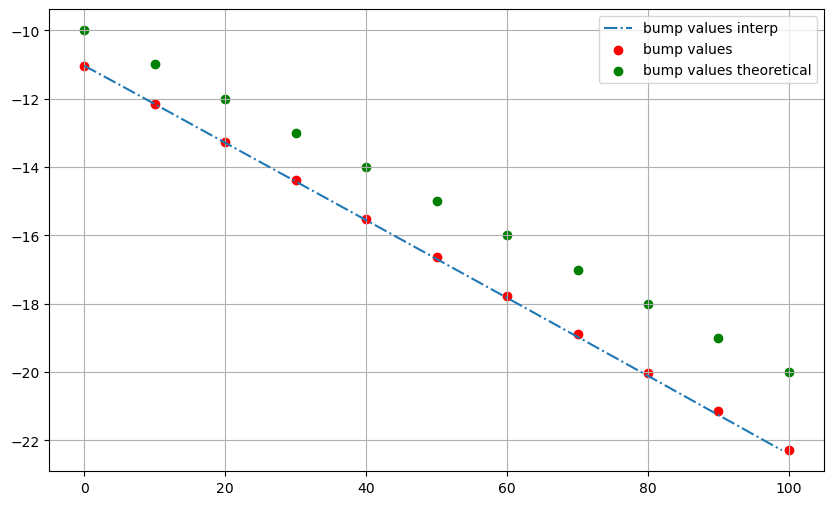

In [238]:
bbt = np.linspace(-10, -20, 100)
bump_vals_interp = bump_map(bbt)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(bump_vals_interp, '-.', label = 'bump values interp')
ax.scatter(np.linspace(0, 100, 11), bump_vals, label='bump values', color='red')
ax.scatter(np.linspace(0, 100, 11), bump_vals_theory, label='bump values theoretical', color='green')
ax.grid()
ax.legend()

# Paths of bumping data

In [12]:
df_params = pd.read_json('../MD_data/20250616/parameters.json').T
df_params.index = pd.to_datetime(df_params.index) #convert index (string timestamp) to datetime
df_params.index = df_params.index.tz_localize("Europe/Paris") #Set to Geneva time

In [13]:
from zoneinfo import ZoneInfo
from datetime import timedelta, datetime

In [14]:
directory = Path('/Users/lisepauwels/sps_simulations/MD_data/20250616/bpm/SPS.USER.MD2')
paths_files_list = list(directory.glob("*.parquet"))
path_files = {}
for path in paths_files_list:
    stem = path.stem
    dt = datetime.strptime(stem, "%Y.%m.%d.%H.%M.%S.%f")
    dt = dt.replace(tzinfo=ZoneInfo("Europe/Paris"))
    path_files[dt] = path
path_files = pd.DataFrame.from_dict(path_files, orient='index', columns=['path'])
path_files.index = pd.to_datetime(path_files.index)
print(path_files.index.is_monotonic_increasing)
path_files = path_files.sort_index() #Files need to be sorted by index for correct time series handling
print(path_files.index.is_monotonic_increasing)

False
True


In [15]:
df_fo = pd.read_json('../MD_data/20250616/full_overview.json').T
df_fo.index = pd.to_datetime(df_fo.index) #convert index (string timestamp) to datetime
df_fo.index = df_fo.index.tz_localize("Europe/Paris") #Set to Geneva time

In [16]:
changes_ts = df_params.index.to_numpy()
dt = timedelta(seconds=1)

In [17]:
# Making new dict with paths per timestamp
paths_per_ts = {}
for ts_start, ts_end in zip(changes_ts[:-1], changes_ts[1:]):
    ll = df_fo.loc[ts_start:ts_end-dt].index.to_numpy()
    lll = path_files.loc[ts_start:ts_end-dt, "path"].to_numpy()
    
    for i in range(len(ll)):
        paths_per_ts[ll[i]] = lll[i]
paths_per_ts = pd.DataFrame.from_dict(paths_per_ts, orient='index', columns=['path'])

In [18]:
df_params.loc["2025-06-16 20:00:00":"2025-06-16 20:18:59"]

,radial_steering,bump,chroma,tune_shift
2025-06-16 20:03:15+02:00,DPneg,0.0,0.5,0.05
2025-06-16 20:04:11+02:00,DPneg,-0.01,0.5,0.05
2025-06-16 20:05:34+02:00,DPneg,-0.011,0.5,0.05
2025-06-16 20:06:57+02:00,DPneg,-0.012,0.5,0.05
2025-06-16 20:09:15+02:00,DPneg,-0.013,0.5,0.05
2025-06-16 20:10:38+02:00,DPneg,-0.014,0.5,0.05
2025-06-16 20:12:01.100000+02:00,DPneg,-0.015,0.5,0.05
2025-06-16 20:13:23+02:00,DPneg,-0.016,0.5,0.05
2025-06-16 20:14:46+02:00,DPneg,-0.017,0.5,0.05
2025-06-16 20:15:41+02:00,DPneg,-0.018,0.5,0.05


In [19]:
timestamps = df_params.loc["2025-06-16 20:04:00":"2025-06-16 20:18:56"].index.to_numpy()
bumps = df_params.loc["2025-06-16 20:04:00":"2025-06-16 20:18:56", 'bump'].to_numpy()

In [20]:
paths = {}
timestamps = df_params.loc["2025-06-16 20:04:00":"2025-06-16 20:19:00"].index.to_numpy()
bumps = df_params.loc["2025-06-16 20:04:00":"2025-06-16 20:19:00", 'bump'].to_numpy()

i = 0
for ts1, ts2 in zip(timestamps[:-1], timestamps[1:]):
    paths[bumps[i]] = paths_per_ts.loc[ts1:ts2, 'path'].values
    i += 1


In [21]:
files = {}
for i, bump in enumerate([-10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20]):
    if bump not in files:
        files[bump] = []
    files[bump] = [ak.Array(ak.from_parquet(paths[bumps[i]][j]), with_name='BPMCollection') for j in range(len(paths[bumps[i]]))]

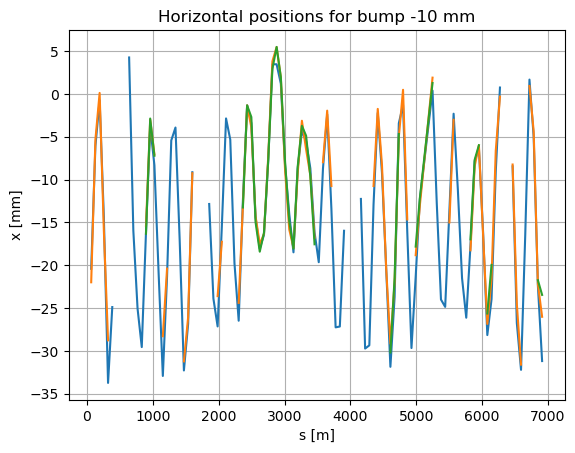

In [331]:
for file in files[-10]:
    plt.plot(s_positions_bpms, file.hor_turn_position[:, -1])
plt.title('Horizontal positions for bump -10 mm')
plt.xlabel('s [m]')
plt.ylabel('x [mm]')
plt.grid()

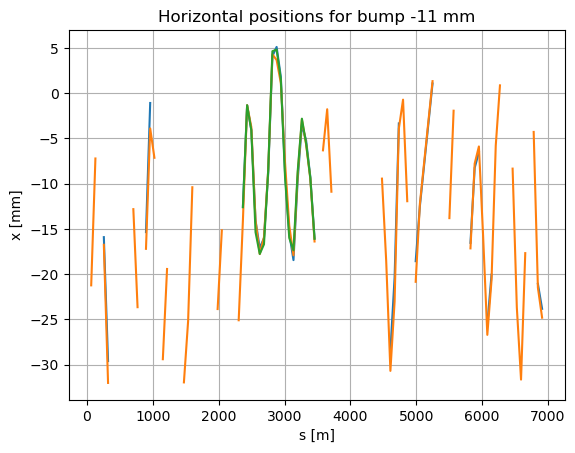

In [332]:
for file in files[-11]:
    plt.plot(s_positions_bpms, file.hor_turn_position[:, -1])
plt.title('Horizontal positions for bump -11 mm')
plt.xlabel('s [m]')
plt.ylabel('x [mm]')
plt.grid()

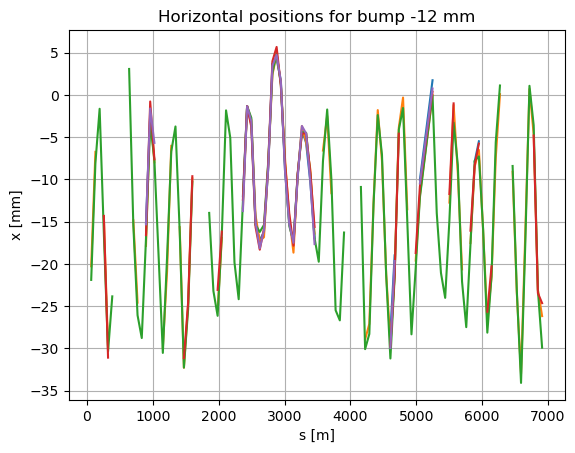

In [333]:
for file in files[-12]:
    plt.plot(s_positions_bpms, file.hor_turn_position[:, -1])
plt.title('Horizontal positions for bump -12 mm') 
plt.xlabel('s [m]')
plt.ylabel('x [mm]')
plt.grid()
# 2 is the best

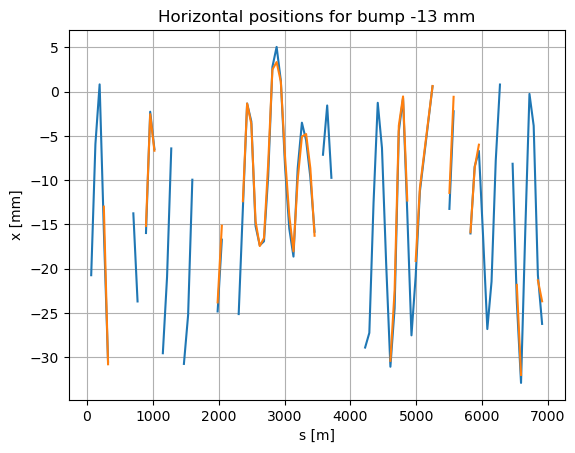

In [334]:
for file in files[-13]:
    plt.plot(s_positions_bpms, file.hor_turn_position[:, -1])
plt.title('Horizontal positions for bump -13 mm') 
plt.xlabel('s [m]')
plt.ylabel('x [mm]')
plt.grid()
# 0 is the best

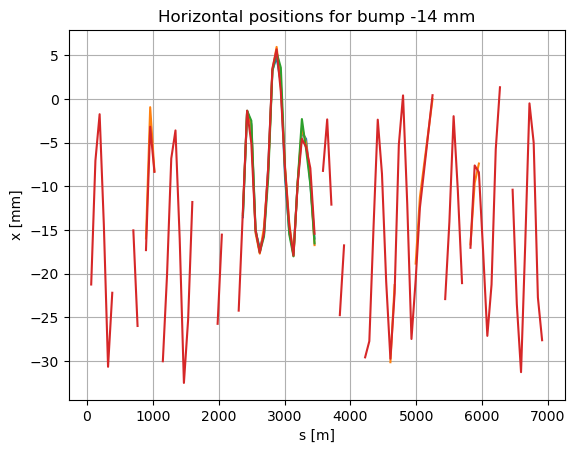

In [335]:
for file in files[-14]:
    plt.plot(s_positions_bpms, file.hor_turn_position[:, -1])
plt.title('Horizontal positions for bump -14 mm') 
plt.xlabel('s [m]')
plt.ylabel('x [mm]')
plt.grid()
# 3 is the best

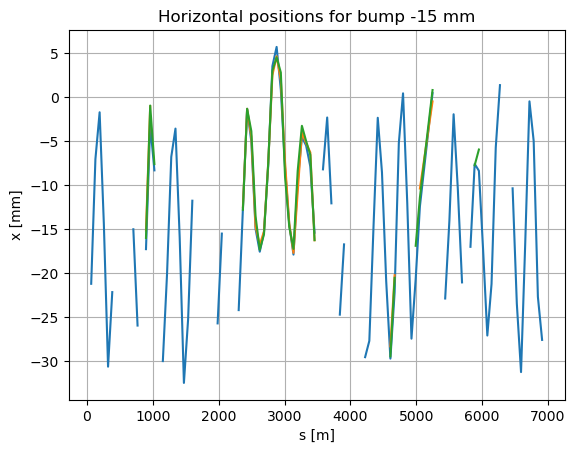

In [336]:
for file in files[-15]:
    plt.plot(s_positions_bpms, file.hor_turn_position[:, -1])
plt.title('Horizontal positions for bump -15 mm')
plt.xlabel('s [m]')
plt.ylabel('x [mm]') 
plt.grid()
# 0 is the best

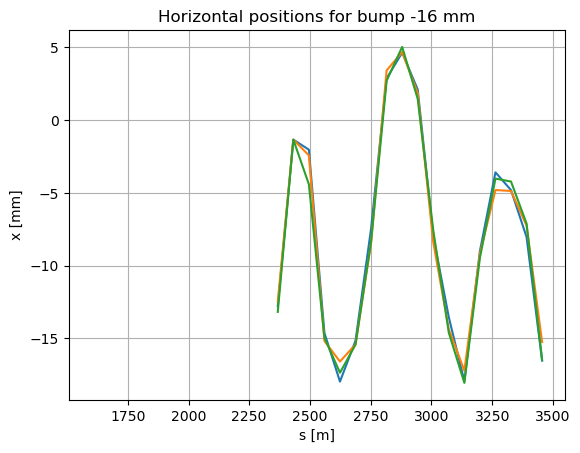

In [337]:
for file in files[-16]:
    plt.plot(s_positions_bpms,file.hor_turn_position[:, -1])
plt.title('Horizontal positions for bump -16 mm') 
plt.xlabel('s [m]')
plt.ylabel('x [mm]')
plt.grid()
# all are good

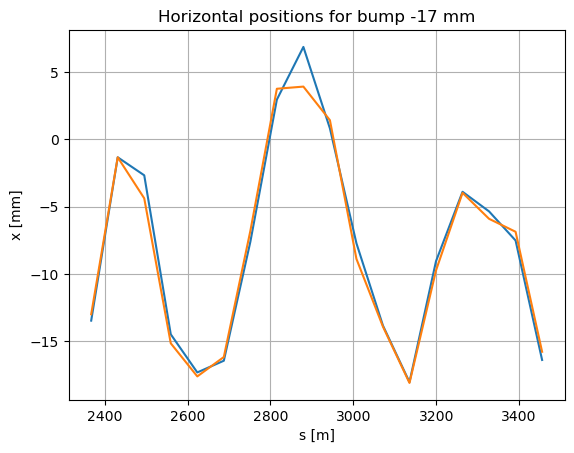

In [338]:
for file in files[-17]:
    plt.plot(s_positions_bpms, file.hor_turn_position[:, -1])
plt.title('Horizontal positions for bump -17 mm')
plt.xlabel('s [m]')
plt.ylabel('x [mm]')
plt.grid() 
# all are good

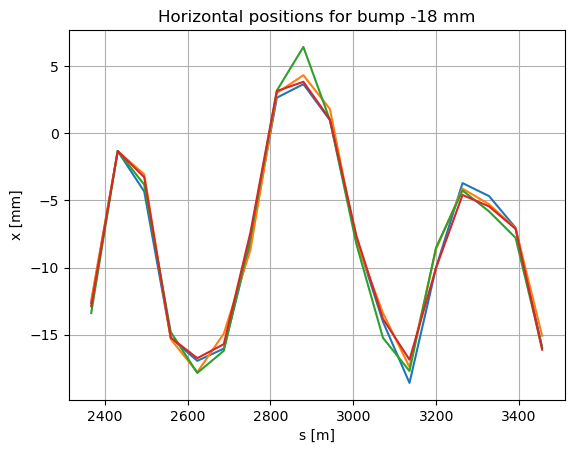

In [339]:
for file in files[-18]:
    plt.plot(s_positions_bpms,file.hor_turn_position[:, -1])
plt.title('Horizontal positions for bump -18 mm') 
plt.xlabel('s [m]')
plt.ylabel('x [mm]')
plt.grid()
# all are good

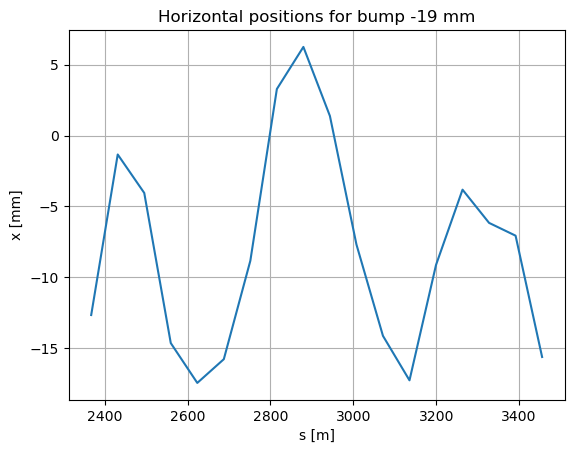

In [ ]:
for file in files[-19]:
    plt.plot(s_positions_bpms,file.hor_turn_position[:, -1])
plt.title('Horizontal positions for bump -19 mm') 
plt.xlabel('s [m]')
plt.ylabel('x [mm]')
plt.grid()
# 0

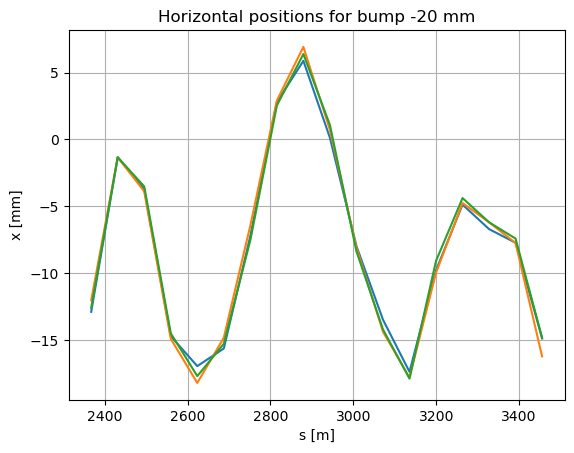

In [341]:
for file in files[-20]:
    plt.plot(s_positions_bpms, file.hor_turn_position[:, -1])
plt.title('Horizontal positions for bump -20 mm')
plt.xlabel('s [m]')
plt.ylabel('x [mm]')
plt.grid()
# all are good

In [26]:
md_data = {-10 : files[-10][0],
           -11 : files[-11][1],
           -12 : files[-12][2],
           -13 : files[-13][0],
           -14 : files[-14][3],
           -15 : files[-15][0],
           -16 : files[-16][0],
           -17 : files[-17][0],
           -18 : files[-18][0],
           -19 : files[-19][0],
           -20 : files[-20][0]}

# Data used as reference for simulation comparison

# It is clear that the bpms do not work all the time as well, kinda arbitrary choice as to what to use

# Simulations

In [27]:
bumps = [-10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20]
orbit_bump_tw = {}
best_turns = {}
particles_element = {}
particles_at_turn = {}
orbit_after_sweep = {}
norms = {}
for i, bump in enumerate(bumps):
    print(f'Bump {bump} mm')
    line = xt.Line.from_json('../injection_lines/sps_orbit_md_20250616.json')
    line['bump.11207'] = bump_corrections[bump][0]
    line['bump.11407'] = bump_corrections[bump][1]
    line['bump.11607'] = bump_corrections[bump][2]

    line.ref['mdh.11207'].knl[0] += line.vars['bump.11207']
    line.ref['mdh.11407'].knl[0] += line.vars['bump.11407']
    line.ref['mdh.11607'].knl[0] += line.vars['bump.11607']


    line.vars['qph_setvalue'] = 0.5
    line.vars['qpv_setvalue'] = 0.5
    line.vars['qh_setvalue'] = line.vars['qx0']._value + 0.05
    line.vars['qv_setvalue'] = line.vars['qy0']._value + 0.05

    tw_bump = line.twiss()
    orbit_bump_tw[bump] = tw_bump

    #Setting cavities to the same frequency and phase, plus setting the voltage
    cavity_elements, cavity_names = line.get_elements_of_type(xt.Cavity)

    for name in cavity_names:
        line[name].frequency = 200e6
        line[name].lag = 180
    line['acl.31735'].voltage = 0 #setting 800 cav to 0V
    line['actcse.31632'].voltage = 3.5e6

    #Context and parameters
    context = xo.ContextCpu()

    num_particles  = 10
    plane = 'DPneg'
    delta_emp = 0.307*get_straight_line(1.967, 1.027,0, 1.967, -22e-3)
    sweep = delta_emp * cavity_elements[0].frequency * tw_ref.slip_factor
    sweep = -abs(sweep) if plane == 'DPpos' else abs(sweep)
    num_turns = 7000

    monitor_names, monitors_elems = insert_monitor_bpms(line, num_turns, num_particles)
    tidp = install_tidp(line)
    tw = line.twiss()
    part = xp.generate_matched_gaussian_bunch(nemitt_x=2e-6,
                                            nemitt_y=2e-6,
                                            sigma_z=0.224, num_particles=num_particles, line=line)
    rf_sweep = xc.RFSweep(line)
    rf_sweep.info(sweep=sweep, num_turns=num_turns)

    line.scattering.enable()
    rf_sweep.track(sweep=sweep, particles=part, num_turns=num_turns, time=True, with_progress=True)
    line.scattering.disable()

    s_positions_monitors, x_positions = post_processing_simulation(line, monitors_elems, part)

    mask_monitors = [True if name in bpm_orbit.bpms_hor[mask_bpm] else False for name in monitor_names]
    mask_None = ak.is_none(md_data[bump].hor_turn_position[mask_bpm][:, -1])
    mask_ba3 = np.array([True if bpm.split('.')[1][0] == '3' else False for bpm in monitor_names[mask_monitors][mask_None]])
    best_turn, distances = moindre_carres(md_data[bump].hor_turn_position[mask_bpm][:, -1], x_positions[:, mask_monitors]*1e3, mask_None )

    best_turns[bump] = best_turn
    particles_element[bump] = part.at_element
    particles_at_turn[bump] = part.at_turn
    orbit_after_sweep[bump] = x_positions[best_turn]  # Convert to mm
    norms[bump] = np.linalg.norm(x_positions[best_turn][mask_monitors][~mask_None]*1e3 - md_data[bump].hor_turn_position[mask_bpm][:, -1][~mask_None])

Bump -10 mm


Loading line from dict:   0%|          | 0/36506 [00:00<?, ?it/s]

Done loading line from dict.           


Slicing line:   0%|          | 0/33114 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/33218 [00:00<?, ?it/s]

*** Maximum RMS bunch length 0.23610110213554214m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.2239999998900487
--> Emittance: 0.30344800513407316
The current frequency is 200000000.0Hz, adding 0.3465359675620472Hz per turn until 200002425.75177294 (for 7000 turns).
This sweep will move the center of the bucket with Δδ = -0.006824942880873933 (-1.0549472351770173 buckets).


Tracking:   0%|          | 0/7000 [00:00<?, ?it/s]

All particles lost at turn 6996, stopped sweep at 2400.454662Hz.
Bump -11 mm


Loading line from dict:   0%|          | 0/36506 [00:00<?, ?it/s]

Done loading line from dict.           


Slicing line:   0%|          | 0/33114 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/33218 [00:00<?, ?it/s]

*** Maximum RMS bunch length 0.2361011021355421m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.22399999989004873
--> Emittance: 0.30344695129505084
The current frequency is 200000000.0Hz, adding 0.3465359675620472Hz per turn until 200002425.75177294 (for 7000 turns).
This sweep will move the center of the bucket with Δδ = -0.006824895476517849 (-1.054943571470075 buckets).


Tracking:   0%|          | 0/7000 [00:00<?, ?it/s]

Bump -12 mm


Loading line from dict:   0%|          | 0/36506 [00:00<?, ?it/s]

Done loading line from dict.           


Slicing line:   0%|          | 0/33114 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/33218 [00:00<?, ?it/s]

*** Maximum RMS bunch length 0.2361011021355421m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.22399999989004873
--> Emittance: 0.30344568293563434
The current frequency is 200000000.0Hz, adding 0.3465359675620472Hz per turn until 200002425.75177294 (for 7000 turns).
This sweep will move the center of the bucket with Δδ = -0.006824838422707845 (-1.0549391619757402 buckets).


Tracking:   0%|          | 0/7000 [00:00<?, ?it/s]

Bump -13 mm


Loading line from dict:   0%|          | 0/36506 [00:00<?, ?it/s]

Done loading line from dict.           


Slicing line:   0%|          | 0/33114 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/33218 [00:00<?, ?it/s]

*** Maximum RMS bunch length 0.23610110213554214m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.2239999998900487
--> Emittance: 0.30344445285607236
The current frequency is 200000000.0Hz, adding 0.3465359675620472Hz per turn until 200002425.75177294 (for 7000 turns).
This sweep will move the center of the bucket with Δδ = -0.0068247830910441315 (-1.0549348855626117 buckets).


Tracking:   0%|          | 0/7000 [00:00<?, ?it/s]

All particles lost at turn 6065, stopped sweep at 2080.948498Hz.
Bump -14 mm


Loading line from dict:   0%|          | 0/36506 [00:00<?, ?it/s]

Done loading line from dict.           


Slicing line:   0%|          | 0/33114 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/33218 [00:00<?, ?it/s]

*** Maximum RMS bunch length 0.23610110213554214m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.2239999998900487
--> Emittance: 0.3034431752866833
The current frequency is 200000000.0Hz, adding 0.3465359675620472Hz per turn until 200002425.75177294 (for 7000 turns).
This sweep will move the center of the bucket with Δδ = -0.006824725623421792 (-1.0549304440494964 buckets).


Tracking:   0%|          | 0/7000 [00:00<?, ?it/s]

Bump -15 mm


Loading line from dict:   0%|          | 0/36506 [00:00<?, ?it/s]

Done loading line from dict.           


Slicing line:   0%|          | 0/33114 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/33218 [00:00<?, ?it/s]

*** Maximum RMS bunch length 0.2361011021355421m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.2239999998900487
--> Emittance: 0.3034418490352105
The current frequency is 200000000.0Hz, adding 0.3465359675620472Hz per turn until 200002425.75177294 (for 7000 turns).
This sweep will move the center of the bucket with Δδ = -0.006824665966238062 (-1.0549258332914726 buckets).


Tracking:   0%|          | 0/7000 [00:00<?, ?it/s]

Bump -16 mm


Loading line from dict:   0%|          | 0/36506 [00:00<?, ?it/s]

Done loading line from dict.           


Slicing line:   0%|          | 0/33114 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/33218 [00:00<?, ?it/s]

*** Maximum RMS bunch length 0.2361011021355421m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.2239999998900487
--> Emittance: 0.30344047288548787
The current frequency is 200000000.0Hz, adding 0.3465359675620472Hz per turn until 200002425.75177294 (for 7000 turns).
This sweep will move the center of the bucket with Δδ = -0.006824604064816687 (-1.054921049060499 buckets).


Tracking:   0%|          | 0/7000 [00:00<?, ?it/s]

All particles lost at turn 6494, stopped sweep at 2228.226285Hz.
Bump -17 mm


Loading line from dict:   0%|          | 0/36506 [00:00<?, ?it/s]

Done loading line from dict.           


Slicing line:   0%|          | 0/33114 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/33218 [00:00<?, ?it/s]

*** Maximum RMS bunch length 0.2361011021355421m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.22399999989004873
--> Emittance: 0.3034390455657796
The current frequency is 200000000.0Hz, adding 0.3465359675620472Hz per turn until 200002425.75177294 (for 7000 turns).
This sweep will move the center of the bucket with Δδ = -0.006824539861983883 (-1.0549160869353424 buckets).


Tracking:   0%|          | 0/7000 [00:00<?, ?it/s]

All particles lost at turn 5721, stopped sweep at 1962.779732Hz.
Bump -18 mm


Loading line from dict:   0%|          | 0/36506 [00:00<?, ?it/s]

Done loading line from dict.           


Slicing line:   0%|          | 0/33114 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/33218 [00:00<?, ?it/s]

*** Maximum RMS bunch length 0.2361011021355421m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.2239999998900487
--> Emittance: 0.3034375657563355
The current frequency is 200000000.0Hz, adding 0.3465359675620472Hz per turn until 200002425.75177294 (for 7000 turns).
This sweep will move the center of the bucket with Δδ = -0.006824473298408358 (-1.0549109423278475 buckets).


Tracking:   0%|          | 0/7000 [00:00<?, ?it/s]

All particles lost at turn 5444, stopped sweep at 1867.828877Hz.
Bump -19 mm


Loading line from dict:   0%|          | 0/36506 [00:00<?, ?it/s]

Done loading line from dict.           


Slicing line:   0%|          | 0/33114 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/33218 [00:00<?, ?it/s]

*** Maximum RMS bunch length 0.23610110213554214m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.22399999989004876
--> Emittance: 0.30343603210168646
The current frequency is 200000000.0Hz, adding 0.3465359675620472Hz per turn until 200002425.75177294 (for 7000 turns).
This sweep will move the center of the bucket with Δδ = -0.006824404313154492 (-1.0549056105256784 buckets).


Tracking:   0%|          | 0/7000 [00:00<?, ?it/s]

All particles lost at turn 4994, stopped sweep at 1713.62037Hz.
Bump -20 mm


Loading line from dict:   0%|          | 0/36506 [00:00<?, ?it/s]

Done loading line from dict.           


Slicing line:   0%|          | 0/33114 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/33218 [00:00<?, ?it/s]

*** Maximum RMS bunch length 0.23610110213554214m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.22399999989004868
--> Emittance: 0.303434443179593
The current frequency is 200000000.0Hz, adding 0.3465359675620472Hz per turn until 200002425.75177294 (for 7000 turns).
This sweep will move the center of the bucket with Δδ = -0.006824332842285855 (-1.0549000865843747 buckets).


Tracking:   0%|          | 0/7000 [00:00<?, ?it/s]

All particles lost at turn 5178, stopped sweep at 1776.689916Hz.


## Bump -10mm

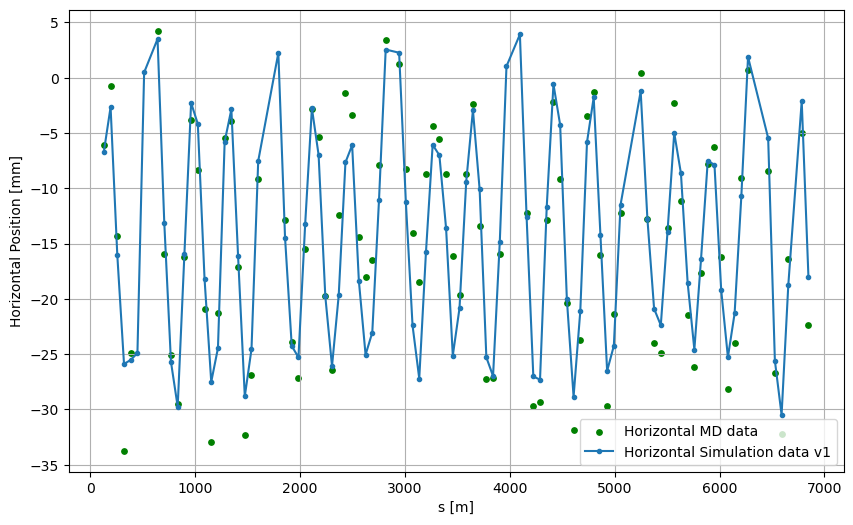

In [38]:
fig, ax = plt.subplots(figsize=(10, 6))
mask_None = ak.is_none(md_data[-10].hor_turn_position[mask_bpm][:, -1])
ax.scatter(s_positions_bpms[mask_bpm][~mask_None], md_data[-10].hor_turn_position[mask_bpm][:, -1][~mask_None], s=15, marker= 'o', color='green', label='Horizontal MD data')
#ax.plot(s_positions_bpms[mask_bpm], md_data.hor_turn_position[mask_bpm][:, 0], '.-.', label='Horizontal MD data first turn')
ax.plot(s_positions_monitors[mask_monitors], orbit_after_sweep[-10][mask_monitors]*1e3, '.-', label='Horizontal Simulation data v1')
ax.set_xlabel('s [m]')
ax.set_ylabel('Horizontal Position [mm]')
ax.grid()
ax.legend()

In [57]:
print('Norm simulation-measurements: ', norms[-10])
print('Death turn : ', particles_at_turn[-10])
print('Particles at element: ', particles_element[-10])
print('Element :', line.element_names[particles_element[-10][0]])
print('Best turn: ', best_turns[-10])

Norm simulation-measurements:  30.658356258881835
Death turn :  [6996 6477 6034 6032 5929 5848 5609 5286 4780 4254]
Particles at element:  [3797 3797 3797 3797 3797 3797 3797 3797 3797 3797]
Element : bpcn.12508.a_aper
Best turn:  3471


## Bump -11mm

In [59]:
bump_val_loc = -11

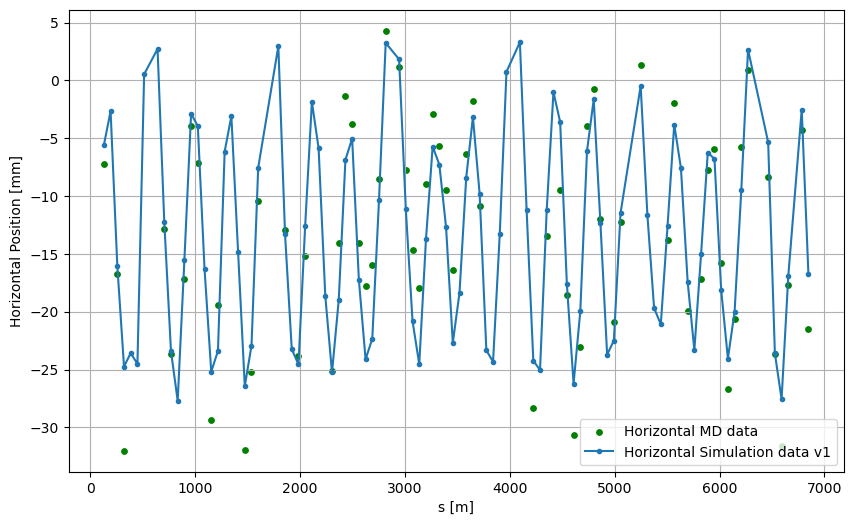

In [60]:
fig, ax = plt.subplots(figsize=(10, 6))
mask_None = ak.is_none(md_data[bump_val_loc].hor_turn_position[mask_bpm][:, -1])
ax.scatter(s_positions_bpms[mask_bpm][~mask_None], md_data[bump_val_loc].hor_turn_position[mask_bpm][:, -1][~mask_None], s=15, marker= 'o', color='green', label='Horizontal MD data')
#ax.plot(s_positions_bpms[mask_bpm], md_data.hor_turn_position[mask_bpm][:, 0], '.-.', label='Horizontal MD data first turn')
ax.plot(s_positions_monitors[mask_monitors], orbit_after_sweep[bump_val_loc][mask_monitors]*1e3, '.-', label='Horizontal Simulation data v1')
ax.set_xlabel('s [m]')
ax.set_ylabel('Horizontal Position [mm]')
ax.grid()
ax.legend()

In [62]:
print('Norm simulation-measurements: ', norms[bump_val_loc])
print('Death turn : ', particles_at_turn[bump_val_loc])
print('Particles at element: ', particles_element[bump_val_loc])
print('Element :', line.element_names[particles_element[bump_val_loc][2]])
print('Best turn: ', best_turns[bump_val_loc])

Norm simulation-measurements:  26.30102415196348
Death turn :  [7000 7000 6700 6557 6364 5644 5620 5126 5104 4893]
Particles at element:  [   0    0 3797 3797 3797 3797 3797 3797 3797 3797]
Element : bpcn.12508.a_aper
Best turn:  3501


## Bump -12mm

Norm simulation-measurements:  29.17448913489111
Death turn :  [7000 7000 6377 6288 6168 5967 5811 5147 4797 4708]
Particles at element:  [   0    0 3797 3797 3797 2176 3797 2493 3797 3797]
Element : bpcn.12508.a_aper
Best turn:  3384


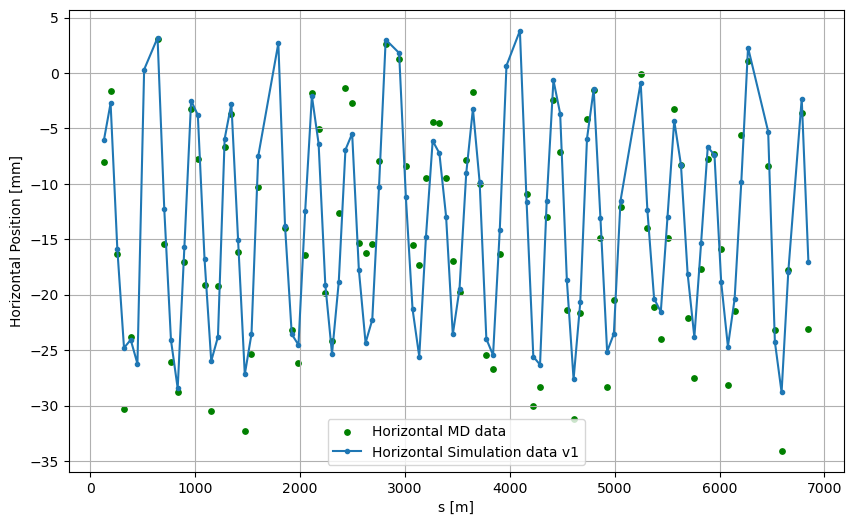

In [63]:
bump_val_loc = -12

fig, ax = plt.subplots(figsize=(10, 6))
mask_None = ak.is_none(md_data[bump_val_loc].hor_turn_position[mask_bpm][:, -1])
ax.scatter(s_positions_bpms[mask_bpm][~mask_None], md_data[bump_val_loc].hor_turn_position[mask_bpm][:, -1][~mask_None], s=15, marker= 'o', color='green', label='Horizontal MD data')
#ax.plot(s_positions_bpms[mask_bpm], md_data.hor_turn_position[mask_bpm][:, 0], '.-.', label='Horizontal MD data first turn')
ax.plot(s_positions_monitors[mask_monitors], orbit_after_sweep[bump_val_loc][mask_monitors]*1e3, '.-', label='Horizontal Simulation data v1')
ax.set_xlabel('s [m]')
ax.set_ylabel('Horizontal Position [mm]')
ax.grid()
ax.legend()

print('Norm simulation-measurements: ', norms[bump_val_loc])
print('Death turn : ', particles_at_turn[bump_val_loc])
print('Particles at element: ', particles_element[bump_val_loc])
print('Element :', line.element_names[particles_element[bump_val_loc][2]])
print('Best turn: ', best_turns[bump_val_loc])

## Bump -13mm

Norm simulation-measurements:  25.02951407112817
Death turn :  [6065 6004 5801 5789 5671 5416 5166 4934 4918 4897]
Particles at element:  [3797 3797 3797 3797 3797 3797 3797 2249 3797 3797]
Element : bpcn.12508.a_aper
Best turn:  3012


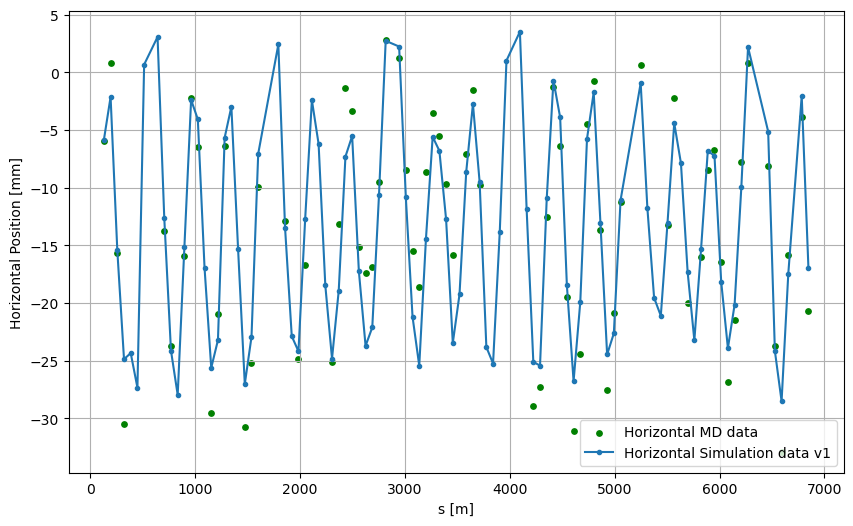

In [64]:
bump_val_loc = -13

fig, ax = plt.subplots(figsize=(10, 6))
mask_None = ak.is_none(md_data[bump_val_loc].hor_turn_position[mask_bpm][:, -1])
ax.scatter(s_positions_bpms[mask_bpm][~mask_None], md_data[bump_val_loc].hor_turn_position[mask_bpm][:, -1][~mask_None], s=15, marker= 'o', color='green', label='Horizontal MD data')
#ax.plot(s_positions_bpms[mask_bpm], md_data.hor_turn_position[mask_bpm][:, 0], '.-.', label='Horizontal MD data first turn')
ax.plot(s_positions_monitors[mask_monitors], orbit_after_sweep[bump_val_loc][mask_monitors]*1e3, '.-', label='Horizontal Simulation data v1')
ax.set_xlabel('s [m]')
ax.set_ylabel('Horizontal Position [mm]')
ax.grid()
ax.legend()

print('Norm simulation-measurements: ', norms[bump_val_loc])
print('Death turn : ', particles_at_turn[bump_val_loc])
print('Particles at element: ', particles_element[bump_val_loc])
print('Element :', line.element_names[particles_element[bump_val_loc][2]])
print('Best turn: ', best_turns[bump_val_loc])

## Bump -14mm

Norm simulation-measurements:  28.522713728194635
Death turn :  [7000 6748 6559 6413 6069 5834 5175 4974 4496 4431]
Particles at element:  [   0 3797 3797 2176 2176 2493 3779 2176 2197 2176]
Element : bpcn.12508.a_aper tidp.11434 mkqh.11653.a_aper vcak.12501.a_aper vebb.11470.a_aper
Best turn:  3508


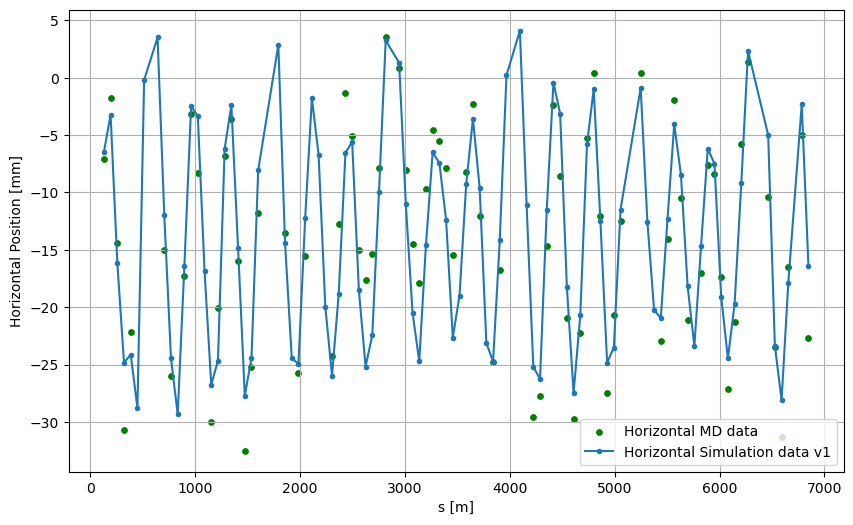

In [67]:
bump_val_loc = -14

fig, ax = plt.subplots(figsize=(10, 6))
mask_None = ak.is_none(md_data[bump_val_loc].hor_turn_position[mask_bpm][:, -1])
ax.scatter(s_positions_bpms[mask_bpm][~mask_None], md_data[bump_val_loc].hor_turn_position[mask_bpm][:, -1][~mask_None], s=15, marker= 'o', color='green', label='Horizontal MD data')
#ax.plot(s_positions_bpms[mask_bpm], md_data.hor_turn_position[mask_bpm][:, 0], '.-.', label='Horizontal MD data first turn')
ax.plot(s_positions_monitors[mask_monitors], orbit_after_sweep[bump_val_loc][mask_monitors]*1e3, '.-', label='Horizontal Simulation data v1')
ax.set_xlabel('s [m]')
ax.set_ylabel('Horizontal Position [mm]')
ax.grid()
ax.legend()

print('Norm simulation-measurements: ', norms[bump_val_loc])
print('Death turn : ', particles_at_turn[bump_val_loc])
print('Particles at element: ', particles_element[bump_val_loc])
print('Element :', line.element_names[3797], line.element_names[2176], line.element_names[2493], 
      line.element_names[3779], line.element_names[2197])
print('Best turn: ', best_turns[bump_val_loc])

3 are lost on the tidp

## -15mm bump

Norm simulation-measurements:  28.561207305259014
Death turn :  [7000 5970 5160 5041 4996 4986 4983 4526 4359 3688]
Particles at element:  [    0  2493  2176  2176 31430  2176  3305  2176  2176  2176]
Elements : ['sps$start', np.str_('tidp.11434'), 'mkqh.11653.a_aper', 'vttm.12202.b_aper', 'vcak.62501.a_aper'] [1 6 1 1 1]
Best turn:  3150


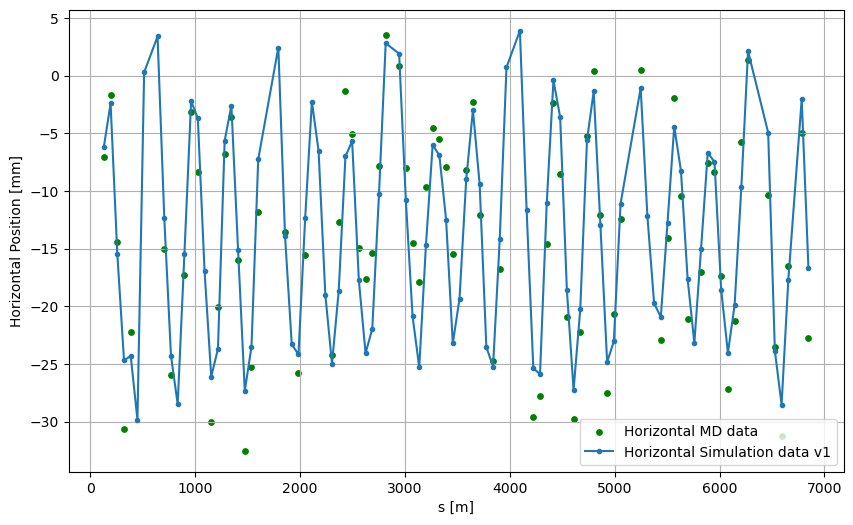

In [71]:
bump_val_loc = -15

fig, ax = plt.subplots(figsize=(10, 6))
mask_None = ak.is_none(md_data[bump_val_loc].hor_turn_position[mask_bpm][:, -1])
ax.scatter(s_positions_bpms[mask_bpm][~mask_None], md_data[bump_val_loc].hor_turn_position[mask_bpm][:, -1][~mask_None], s=15, marker= 'o', color='green', label='Horizontal MD data')
#ax.plot(s_positions_bpms[mask_bpm], md_data.hor_turn_position[mask_bpm][:, 0], '.-.', label='Horizontal MD data first turn')
ax.plot(s_positions_monitors[mask_monitors], orbit_after_sweep[bump_val_loc][mask_monitors]*1e3, '.-', label='Horizontal Simulation data v1')
ax.set_xlabel('s [m]')
ax.set_ylabel('Horizontal Position [mm]')
ax.grid()
ax.legend()

print('Norm simulation-measurements: ', norms[bump_val_loc])
print('Death turn : ', particles_at_turn[bump_val_loc])
print('Particles at element: ', particles_element[bump_val_loc])
idxs, c = np.unique(particles_element[bump_val_loc], return_counts=True)
print('Elements :', [line.element_names[idx] for idx in idxs], c)
print('Best turn: ', best_turns[bump_val_loc])

## -16mm bump

Norm simulation-measurements:  4.918829003752775
Death turn :  [6494 6245 5587 5329 4982 4881 4772 3948 3939 3850]
Particles at element:  [ 2493  2176 14781  3779  2176  2176  2176  2347  2176  2251]
Elements : [np.str_('tidp.11434'), 'mbb.11490..10_aper2', 'veba.11570.a_aper', 'mkqh.11653.a_aper', 'vcak.12501.a_aper', 'vcak.32501.a_aper'] [5 1 1 1 1 1]
Best turn:  2631


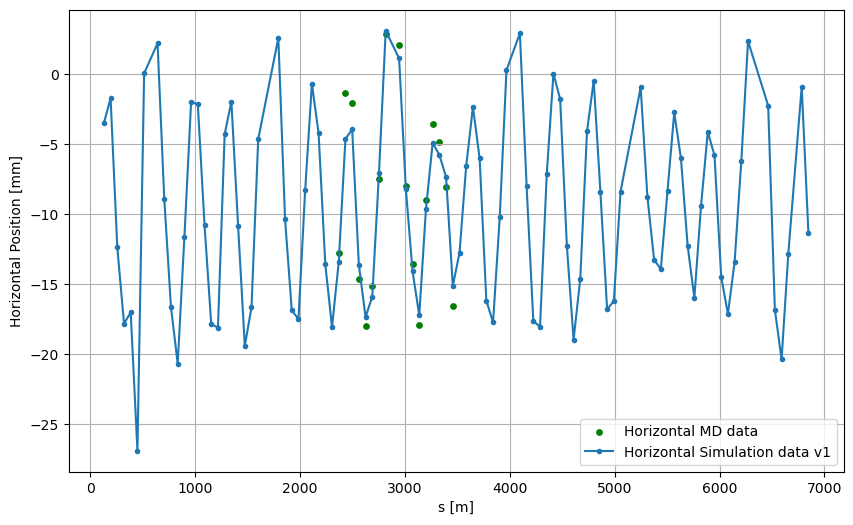

In [72]:
bump_val_loc = -16

fig, ax = plt.subplots(figsize=(10, 6))
mask_None = ak.is_none(md_data[bump_val_loc].hor_turn_position[mask_bpm][:, -1])
ax.scatter(s_positions_bpms[mask_bpm][~mask_None], md_data[bump_val_loc].hor_turn_position[mask_bpm][:, -1][~mask_None], s=15, marker= 'o', color='green', label='Horizontal MD data')
#ax.plot(s_positions_bpms[mask_bpm], md_data.hor_turn_position[mask_bpm][:, 0], '.-.', label='Horizontal MD data first turn')
ax.plot(s_positions_monitors[mask_monitors], orbit_after_sweep[bump_val_loc][mask_monitors]*1e3, '.-', label='Horizontal Simulation data v1')
ax.set_xlabel('s [m]')
ax.set_ylabel('Horizontal Position [mm]')
ax.grid()
ax.legend()

print('Norm simulation-measurements: ', norms[bump_val_loc])
print('Death turn : ', particles_at_turn[bump_val_loc])
print('Particles at element: ', particles_element[bump_val_loc])
idxs, c = np.unique(particles_element[bump_val_loc], return_counts=True)
print('Elements :', [line.element_names[idx] for idx in idxs], c)
print('Best turn: ', best_turns[bump_val_loc])

## -17mm bump

Norm simulation-measurements:  4.156807843039743
Death turn :  [5721 5609 5255 4985 4700 4500 4348 3848 3228 2801]
Particles at element:  [ 2410  2176  3797  2493  2347  2176  2195  4093 14781  2176]
Elements : [np.str_('tidp.11434'), 'vcag.11452.b_aper', 'veba.11570.a_aper', 'vttb.11601.b_aper', 'mkqh.11653.a_aper', 'bpcn.12508.a_aper', 'vcad.12702.a_aper', 'vcak.32501.a_aper'] [3 1 1 1 1 1 1 1]
Best turn:  3348


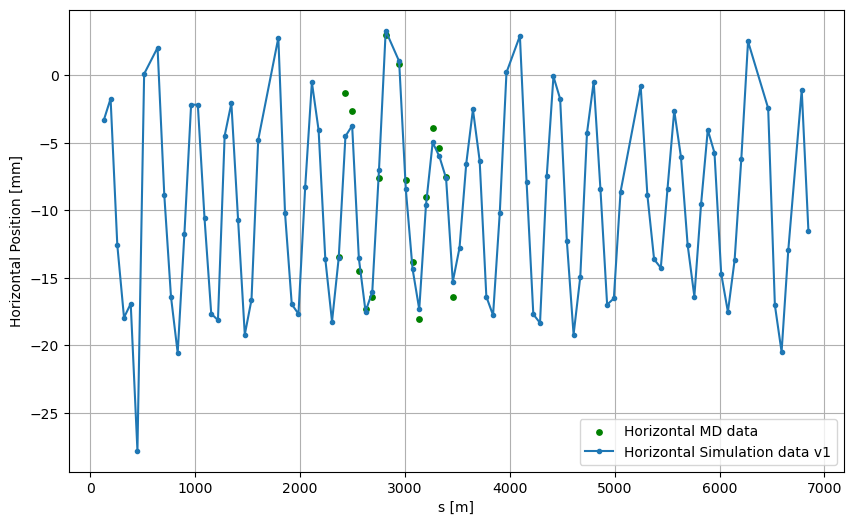

In [73]:
bump_val_loc = -17

fig, ax = plt.subplots(figsize=(10, 6))
mask_None = ak.is_none(md_data[bump_val_loc].hor_turn_position[mask_bpm][:, -1])
ax.scatter(s_positions_bpms[mask_bpm][~mask_None], md_data[bump_val_loc].hor_turn_position[mask_bpm][:, -1][~mask_None], s=15, marker= 'o', color='green', label='Horizontal MD data')
#ax.plot(s_positions_bpms[mask_bpm], md_data.hor_turn_position[mask_bpm][:, 0], '.-.', label='Horizontal MD data first turn')
ax.plot(s_positions_monitors[mask_monitors], orbit_after_sweep[bump_val_loc][mask_monitors]*1e3, '.-', label='Horizontal Simulation data v1')
ax.set_xlabel('s [m]')
ax.set_ylabel('Horizontal Position [mm]')
ax.grid()
ax.legend()

print('Norm simulation-measurements: ', norms[bump_val_loc])
print('Death turn : ', particles_at_turn[bump_val_loc])
print('Particles at element: ', particles_element[bump_val_loc])
idxs, c = np.unique(particles_element[bump_val_loc], return_counts=True)
print('Elements :', [line.element_names[idx] for idx in idxs], c)
print('Best turn: ', best_turns[bump_val_loc])

## -18mm bump

Norm simulation-measurements:  4.3654364504789545
Death turn :  [5444 4863 4745 4547 4439 4401 4295 4023 3595 1805]
Particles at element:  [3298 2176 2195 2176 2176 2249 2176 2493 2176 2221]
Elements : [np.str_('tidp.11434'), 'vcag.11452.b_aper', 'mbb.11470..10_aper2', 'mbb.11490..9_aper2', 'mkqh.11653.a_aper', 'vcag.12195.b_aper'] [5 1 1 1 1 1]
Best turn:  2826


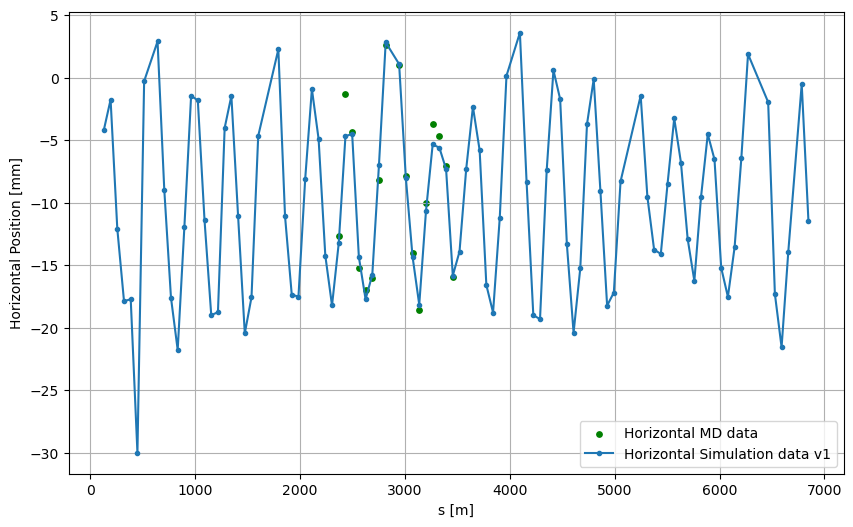

In [74]:
bump_val_loc = -18

fig, ax = plt.subplots(figsize=(10, 6))
mask_None = ak.is_none(md_data[bump_val_loc].hor_turn_position[mask_bpm][:, -1])
ax.scatter(s_positions_bpms[mask_bpm][~mask_None], md_data[bump_val_loc].hor_turn_position[mask_bpm][:, -1][~mask_None], s=15, marker= 'o', color='green', label='Horizontal MD data')
#ax.plot(s_positions_bpms[mask_bpm], md_data.hor_turn_position[mask_bpm][:, 0], '.-.', label='Horizontal MD data first turn')
ax.plot(s_positions_monitors[mask_monitors], orbit_after_sweep[bump_val_loc][mask_monitors]*1e3, '.-', label='Horizontal Simulation data v1')
ax.set_xlabel('s [m]')
ax.set_ylabel('Horizontal Position [mm]')
ax.grid()
ax.legend()

print('Norm simulation-measurements: ', norms[bump_val_loc])
print('Death turn : ', particles_at_turn[bump_val_loc])
print('Particles at element: ', particles_element[bump_val_loc])
idxs, c = np.unique(particles_element[bump_val_loc], return_counts=True)
print('Elements :', [line.element_names[idx] for idx in idxs], c)
print('Best turn: ', best_turns[bump_val_loc])

## -19mm bump

Norm simulation-measurements:  4.312676757823862
Death turn :  [4994 4449 4218 4004 3914 3716 3532 3507 3353 2852]
Particles at element:  [ 2176  2497 14781 31430  2176 14781  2197 14781  3917  2493]
Elements : [np.str_('tidp.11434'), 'vebb.11470.a_aper', 'mkqh.11653.a_aper', 'mkqh.11653.b_aper', 'mba.12590..7_aper2', 'vcak.32501.a_aper', 'vcak.62501.a_aper'] [2 1 1 1 1 3 1]
Best turn:  2242


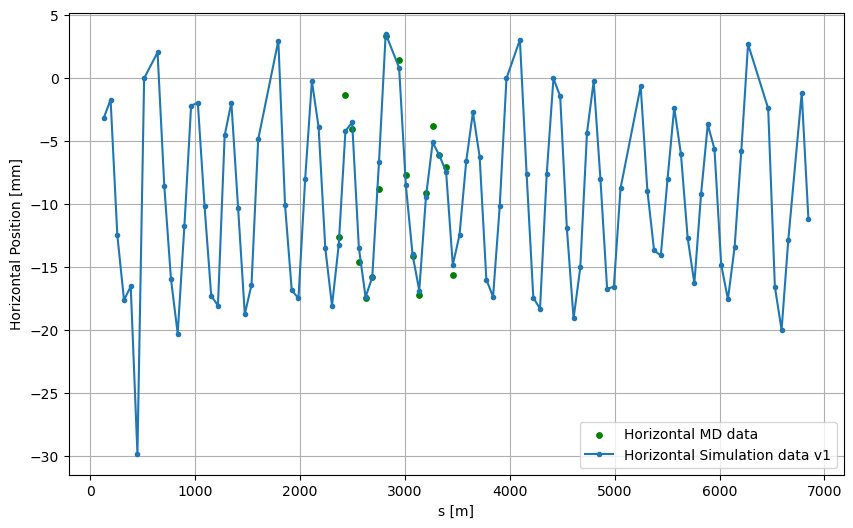

In [75]:
bump_val_loc = -19

fig, ax = plt.subplots(figsize=(10, 6))
mask_None = ak.is_none(md_data[bump_val_loc].hor_turn_position[mask_bpm][:, -1])
ax.scatter(s_positions_bpms[mask_bpm][~mask_None], md_data[bump_val_loc].hor_turn_position[mask_bpm][:, -1][~mask_None], s=15, marker= 'o', color='green', label='Horizontal MD data')
#ax.plot(s_positions_bpms[mask_bpm], md_data.hor_turn_position[mask_bpm][:, 0], '.-.', label='Horizontal MD data first turn')
ax.plot(s_positions_monitors[mask_monitors], orbit_after_sweep[bump_val_loc][mask_monitors]*1e3, '.-', label='Horizontal Simulation data v1')
ax.set_xlabel('s [m]')
ax.set_ylabel('Horizontal Position [mm]')
ax.grid()
ax.legend()

print('Norm simulation-measurements: ', norms[bump_val_loc])
print('Death turn : ', particles_at_turn[bump_val_loc])
print('Particles at element: ', particles_element[bump_val_loc])
idxs, c = np.unique(particles_element[bump_val_loc], return_counts=True)
print('Elements :', [line.element_names[idx] for idx in idxs], c)
print('Best turn: ', best_turns[bump_val_loc])

## -20mm bump

Norm simulation-measurements:  3.60459865341996
Death turn :  [5178 4866 4701 4651 4503 4322 4015 3955 3234 2968]
Particles at element:  [9262 2176 2347 2176 2181 4093 2176 3779 2287 2195]
Elements : [np.str_('tidp.11434'), 'vbba.11451.a_aper', 'vcag.11452.b_aper', 'vebb.11530.a_aper', 'veba.11570.a_aper', 'vcak.12501.a_aper', 'vcad.12702.a_aper', 'vcak.22501.a_aper'] [3 1 1 1 1 1 1 1]
Best turn:  2449


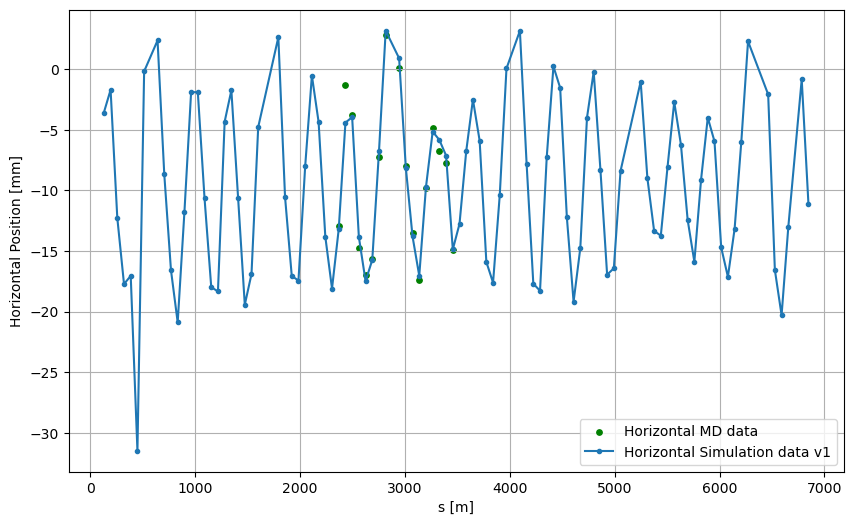

In [76]:
bump_val_loc = -20

fig, ax = plt.subplots(figsize=(10, 6))
mask_None = ak.is_none(md_data[bump_val_loc].hor_turn_position[mask_bpm][:, -1])
ax.scatter(s_positions_bpms[mask_bpm][~mask_None], md_data[bump_val_loc].hor_turn_position[mask_bpm][:, -1][~mask_None], s=15, marker= 'o', color='green', label='Horizontal MD data')
#ax.plot(s_positions_bpms[mask_bpm], md_data.hor_turn_position[mask_bpm][:, 0], '.-.', label='Horizontal MD data first turn')
ax.plot(s_positions_monitors[mask_monitors], orbit_after_sweep[bump_val_loc][mask_monitors]*1e3, '.-', label='Horizontal Simulation data v1')
ax.set_xlabel('s [m]')
ax.set_ylabel('Horizontal Position [mm]')
ax.grid()
ax.legend()

print('Norm simulation-measurements: ', norms[bump_val_loc])
print('Death turn : ', particles_at_turn[bump_val_loc])
print('Particles at element: ', particles_element[bump_val_loc])
idxs, c = np.unique(particles_element[bump_val_loc], return_counts=True)
print('Elements :', [line.element_names[idx] for idx in idxs], c)
print('Best turn: ', best_turns[bump_val_loc])